In [1]:
%cd ..
%load_ext autoreload

/ems/elsc-labs/mezer-a/niv.amos/repos/qMRI Analyzer - Code


In [2]:
import enum
import seaborn as sns
from data_handling.Data_Processor import DataProcessor
from data_handling.Data_Reader import DataReader
import constants
import os
from statistics_methods.Statistics import StatisticsWrapper
from statistics_methods.plots import PlotsManager
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, fcluster
import wandb
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, mean_squared_error as MSE
from xgboost import XGBRegressor
from sklearn.cluster import KMeans
from scipy import stats
from scipy.stats import linregress
import copy
import nibabel as nib

Constants

In [3]:
chosen_rois_dict = constants.ROI_CORTEX
params_to_work_with = constants.ALL_PARAMS
slopes = constants.SLOPES

Load the data and proccess it

In [4]:
def load_data(data_path, outliers=[]):
    col_names = ['subjects', 'Age', 'Gender', 'Clinc_group']
    subjects_raw_data = DataProcessor(data_path, chosen_rois_dict, chosen_rois_dict, col_names).get_data_proccessed()
    analyzed_data = StatisticsWrapper.calc_median_per_subject_per_parameter_per_ROI(subjects_raw_data, params_to_work_with)
    chosen_data = StatisticsWrapper.chose_relevant_data(analyzed_data, chosen_rois_dict, params_to_work_with, params_to_work_with)

    chosen_data = chosen_data[~chosen_data.subjects.isin(outliers)]

    ctl_subjects = chosen_data[chosen_data.Clinc_group == 'CTL']
    pd_subjects = chosen_data[chosen_data.Clinc_group == 'PD']

    return chosen_data, ctl_subjects, pd_subjects 

def normalize_params(data, params):
    data_copy = copy.deepcopy(data)

    for _, subject in data_copy.groupby('subjects'):
        for param in params:
            subject[param] = stats.zscore(subject[param], nan_policy='omit')
            pass

    return data_copy    
    

In [5]:
outliers = ['PD028_YO', 'PD037_ES', 'PD044_TS', 'PD056_YK', 'PD040_JW', 'PD078_DS']
chosen_data_raw, ctl_subjects_raw, pd_subjects_raw = load_data(constants.PATH_TO_PD_CORTEX_all_params_raw, outliers=outliers)
chosen_data_z_score, ctl_subjects_z_score, pd_subjects_z_score = load_data(constants.PATH_TO_PD_CORTEX_all_params_z_score, outliers=outliers)

print(f'ctl: {ctl_subjects_raw.subjects.nunique()}, pd: {pd_subjects_raw.subjects.nunique()}')

ctl: 18, pd: 27


In [8]:
DataProcessor.outliers_counter(ctl_subjects_raw, params_to_work_with, chosen_rois_dict)

outliers counter: {'PD054_ET': 7, 'PD066_TR': 5, 'PD107_AH': 4, 'PD050_YM': 4, 'PD084_JM': 3, 'PD110_DS': 2, 'PD083_NT': 2, 'PD038_IC': 1, 'PD104_MB': 1, 'PD087_LG': 1, 'PD105_FS': 1, 'PD086_DG': 1, 'PD108_AY': 1}


## Raw data analysis 

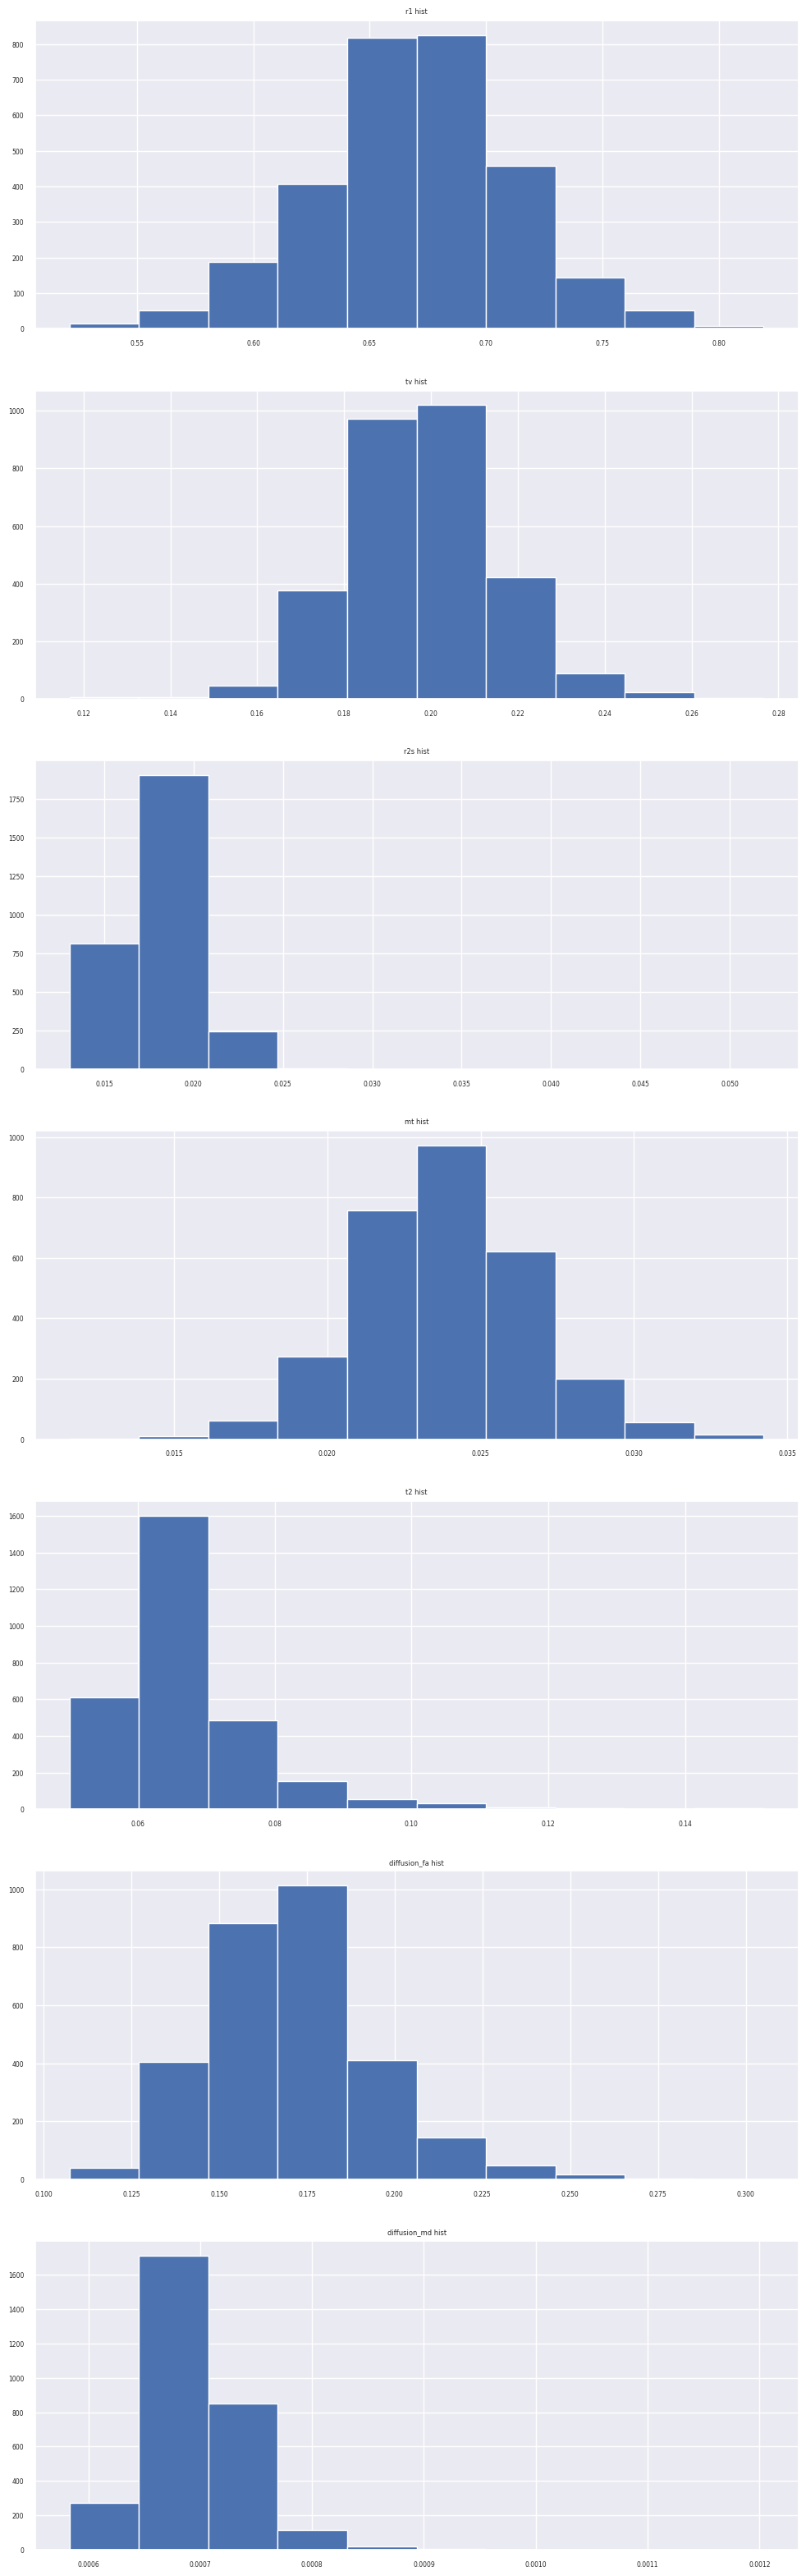

In [28]:
fig, ax = plt.subplots(nrows=7, ncols=1, figsize=(12, 40))

for i, param in  enumerate(params_to_work_with):
    ax[i].set_title(f'{param} hist')
    ax[i].hist(chosen_data_z_score[param])

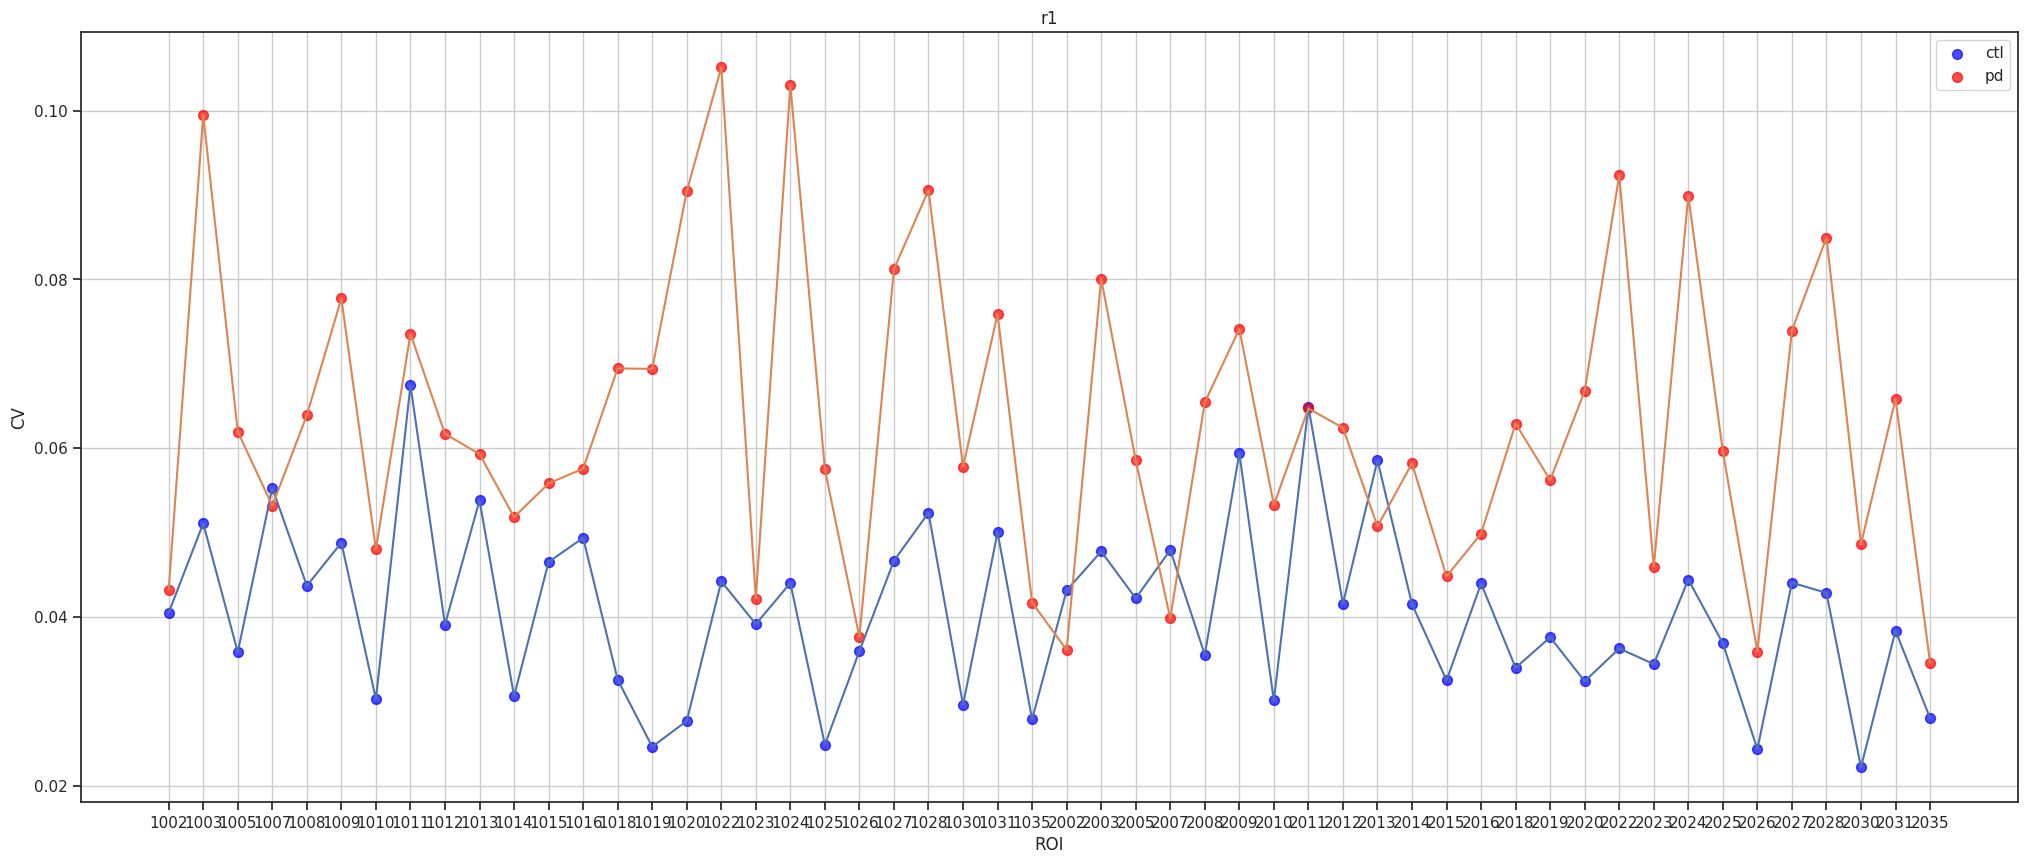

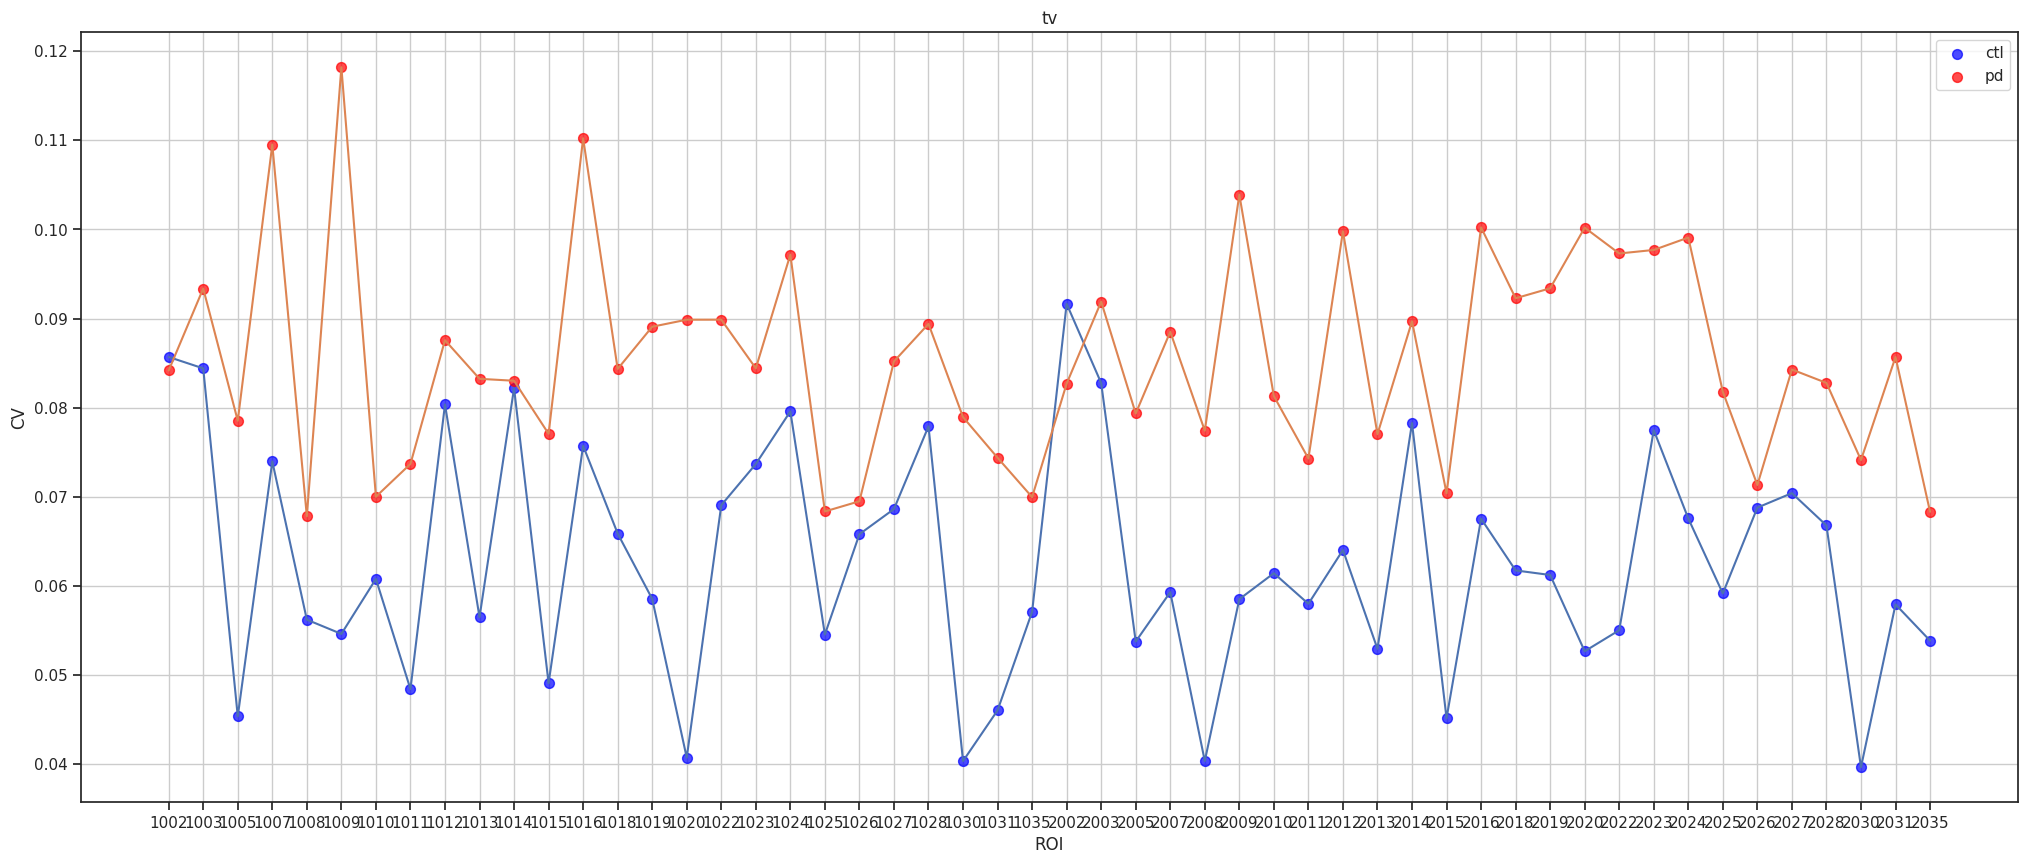

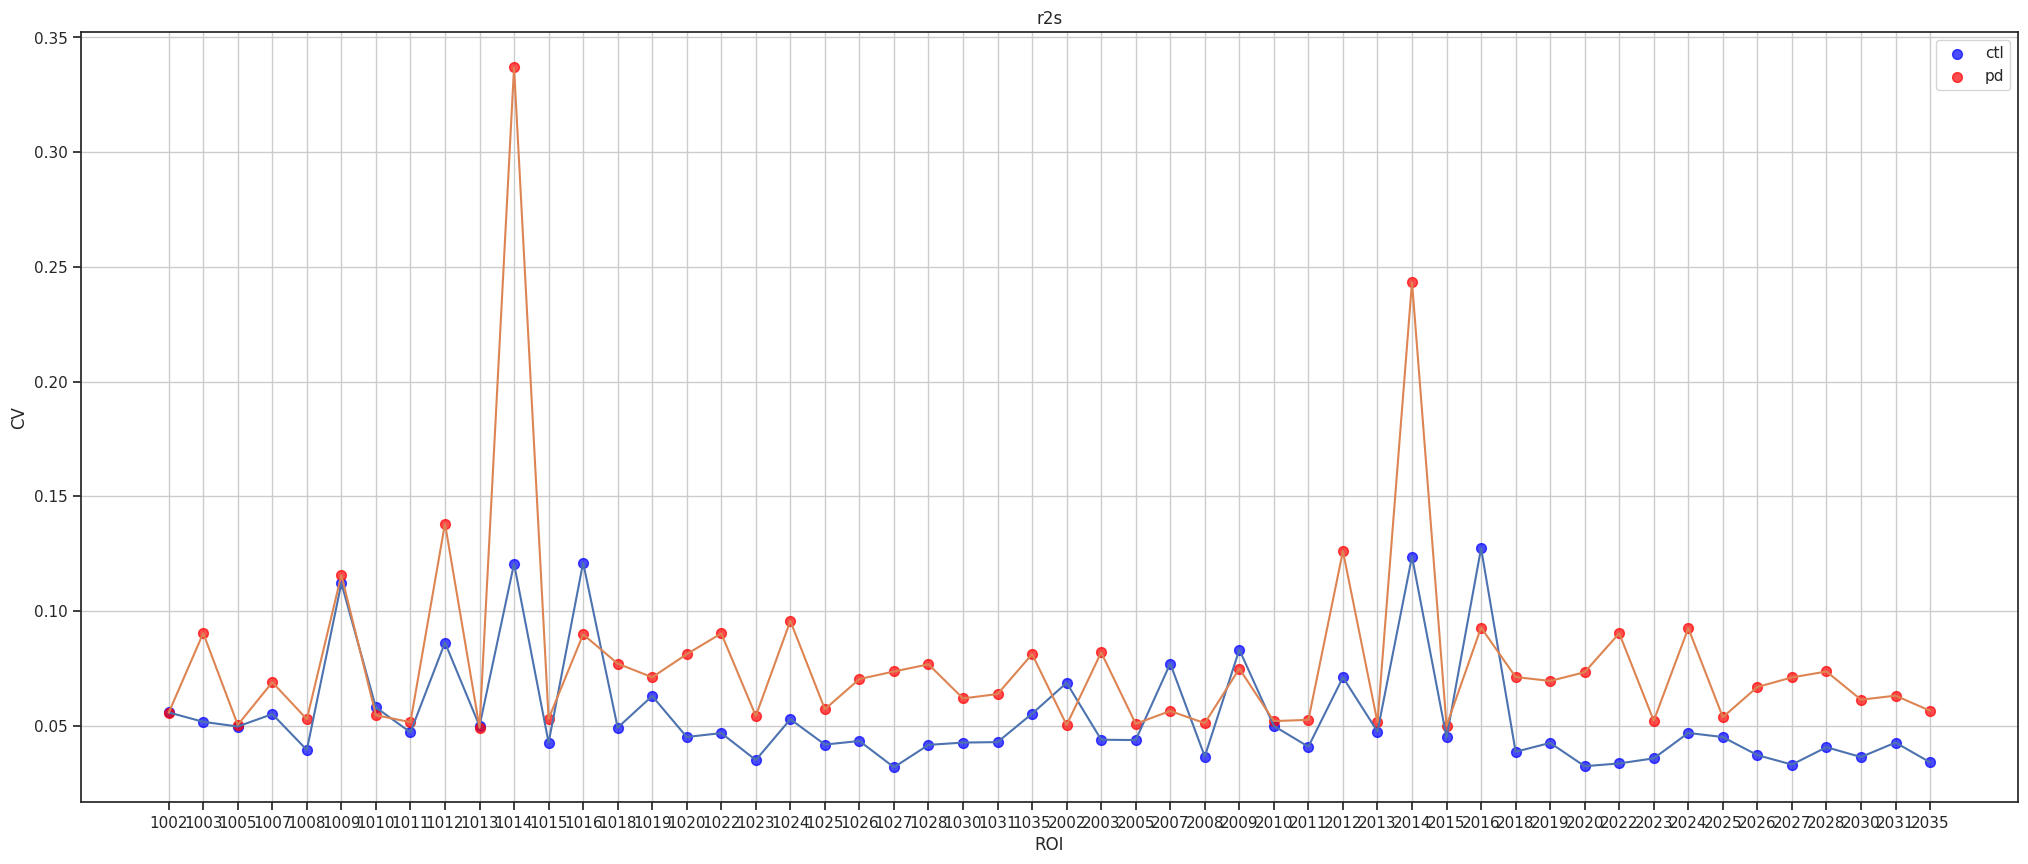

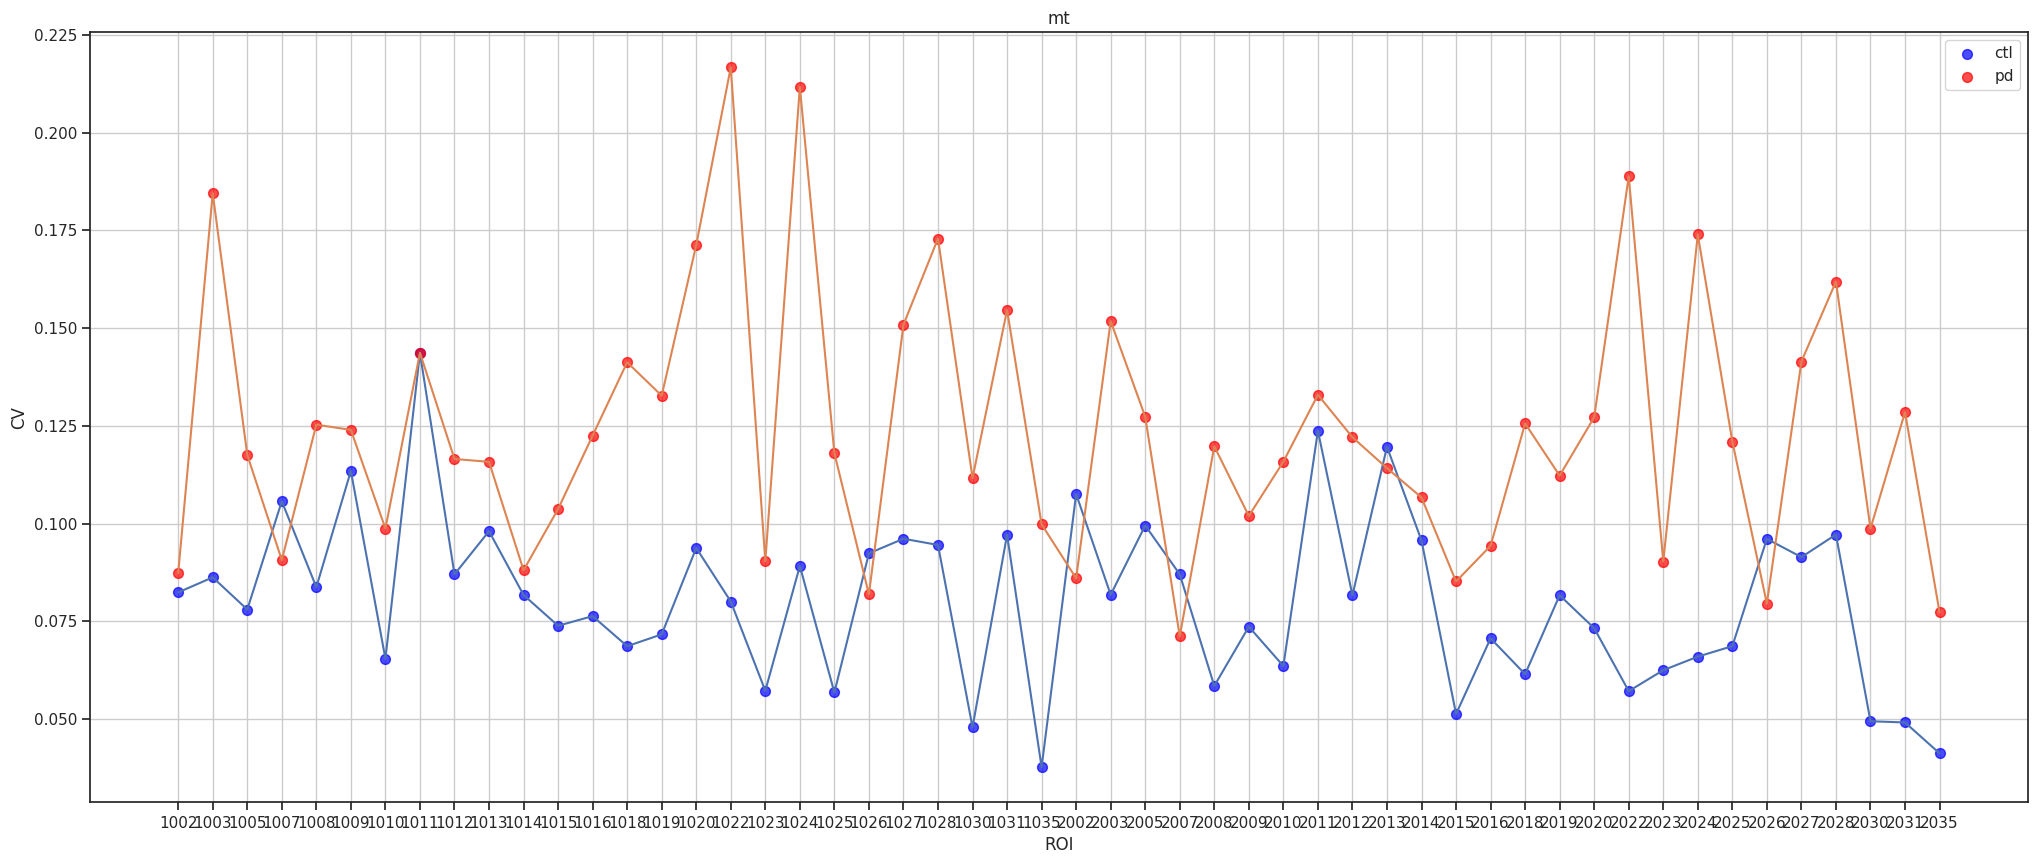

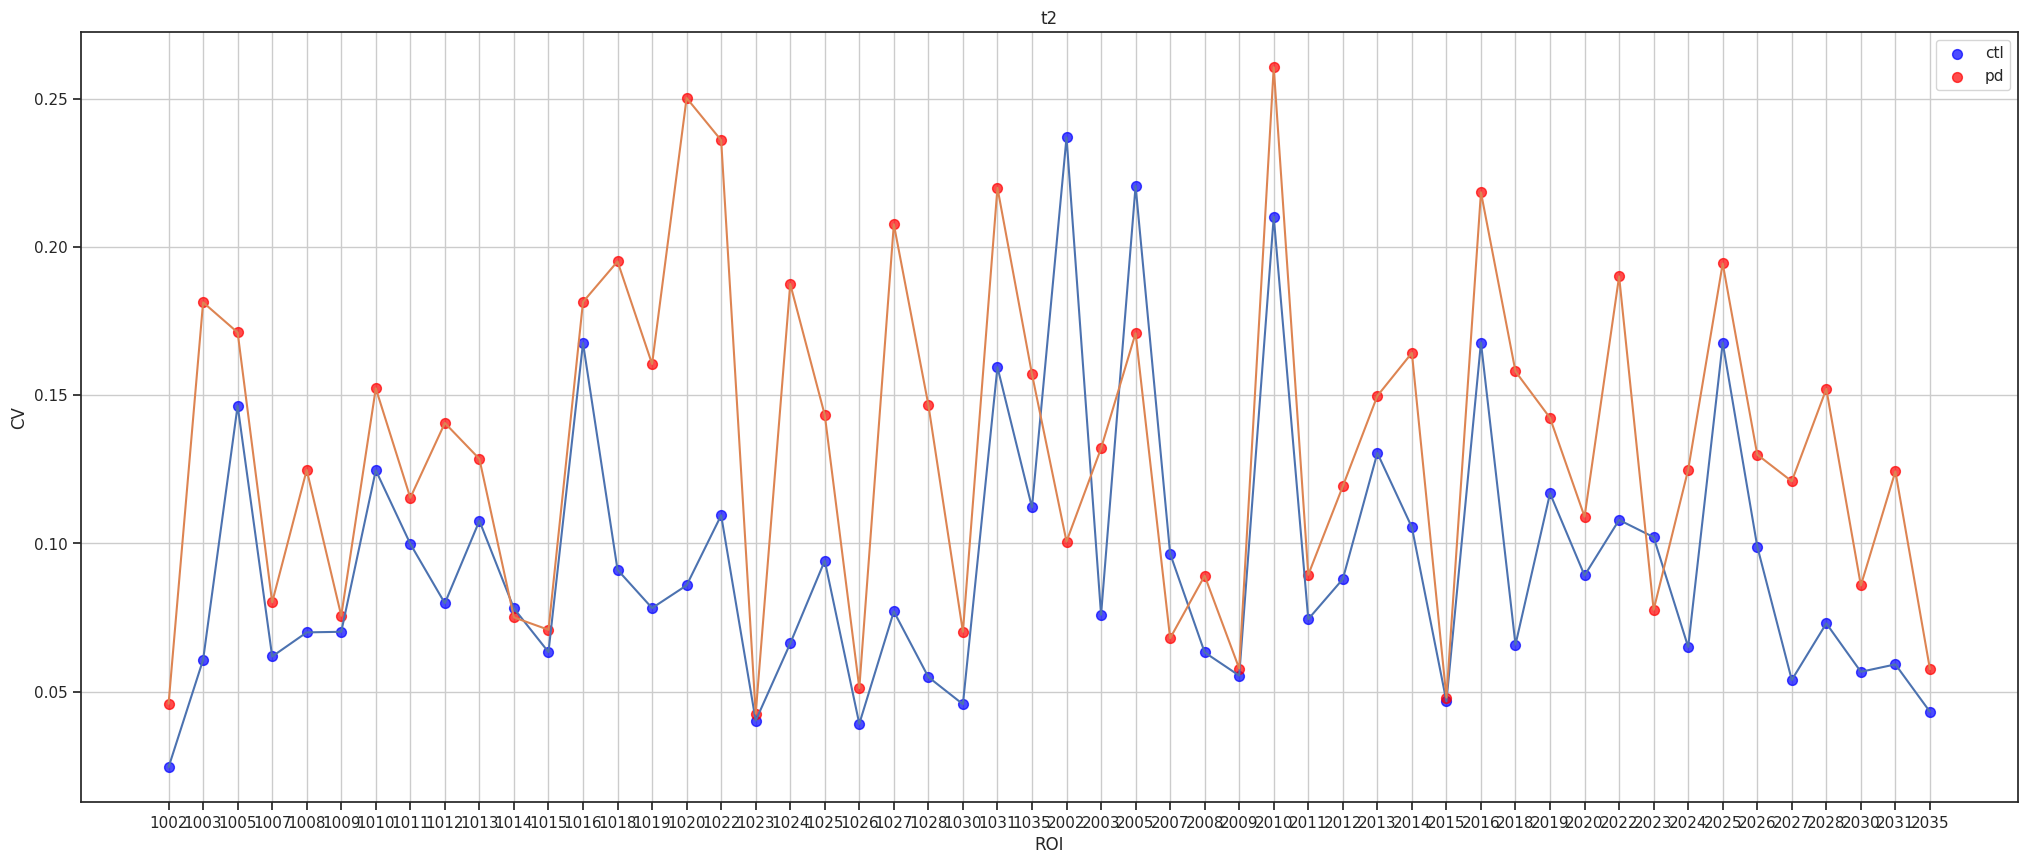

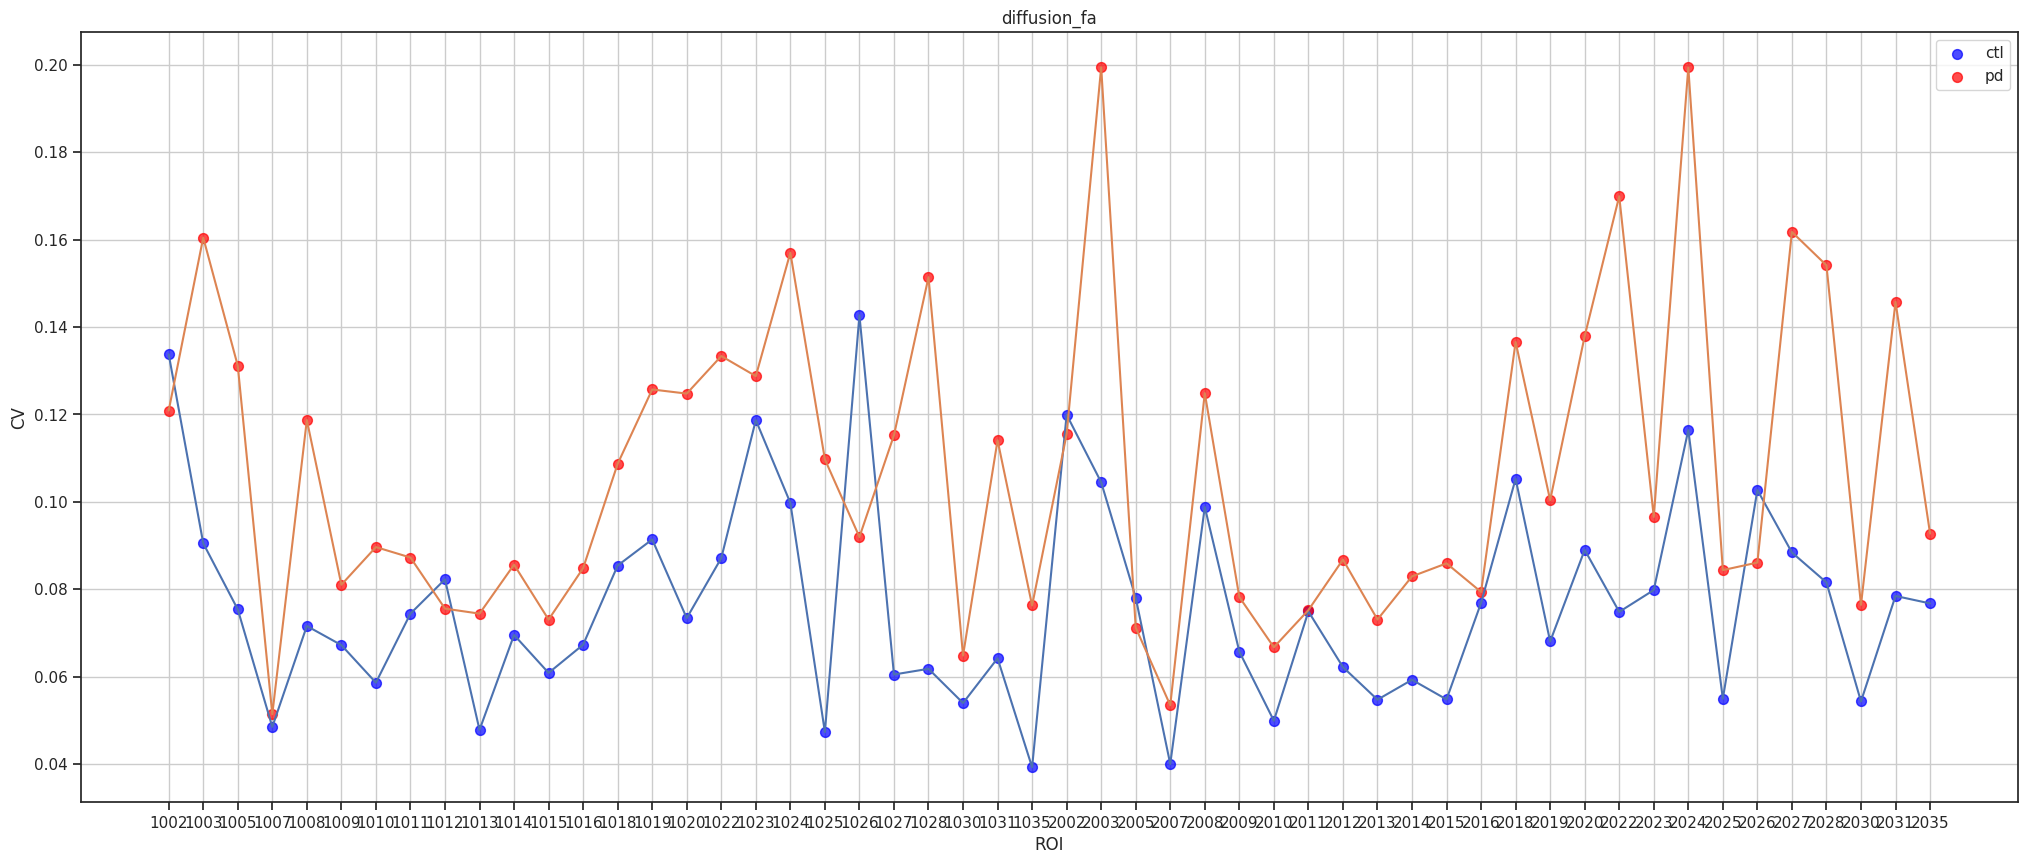

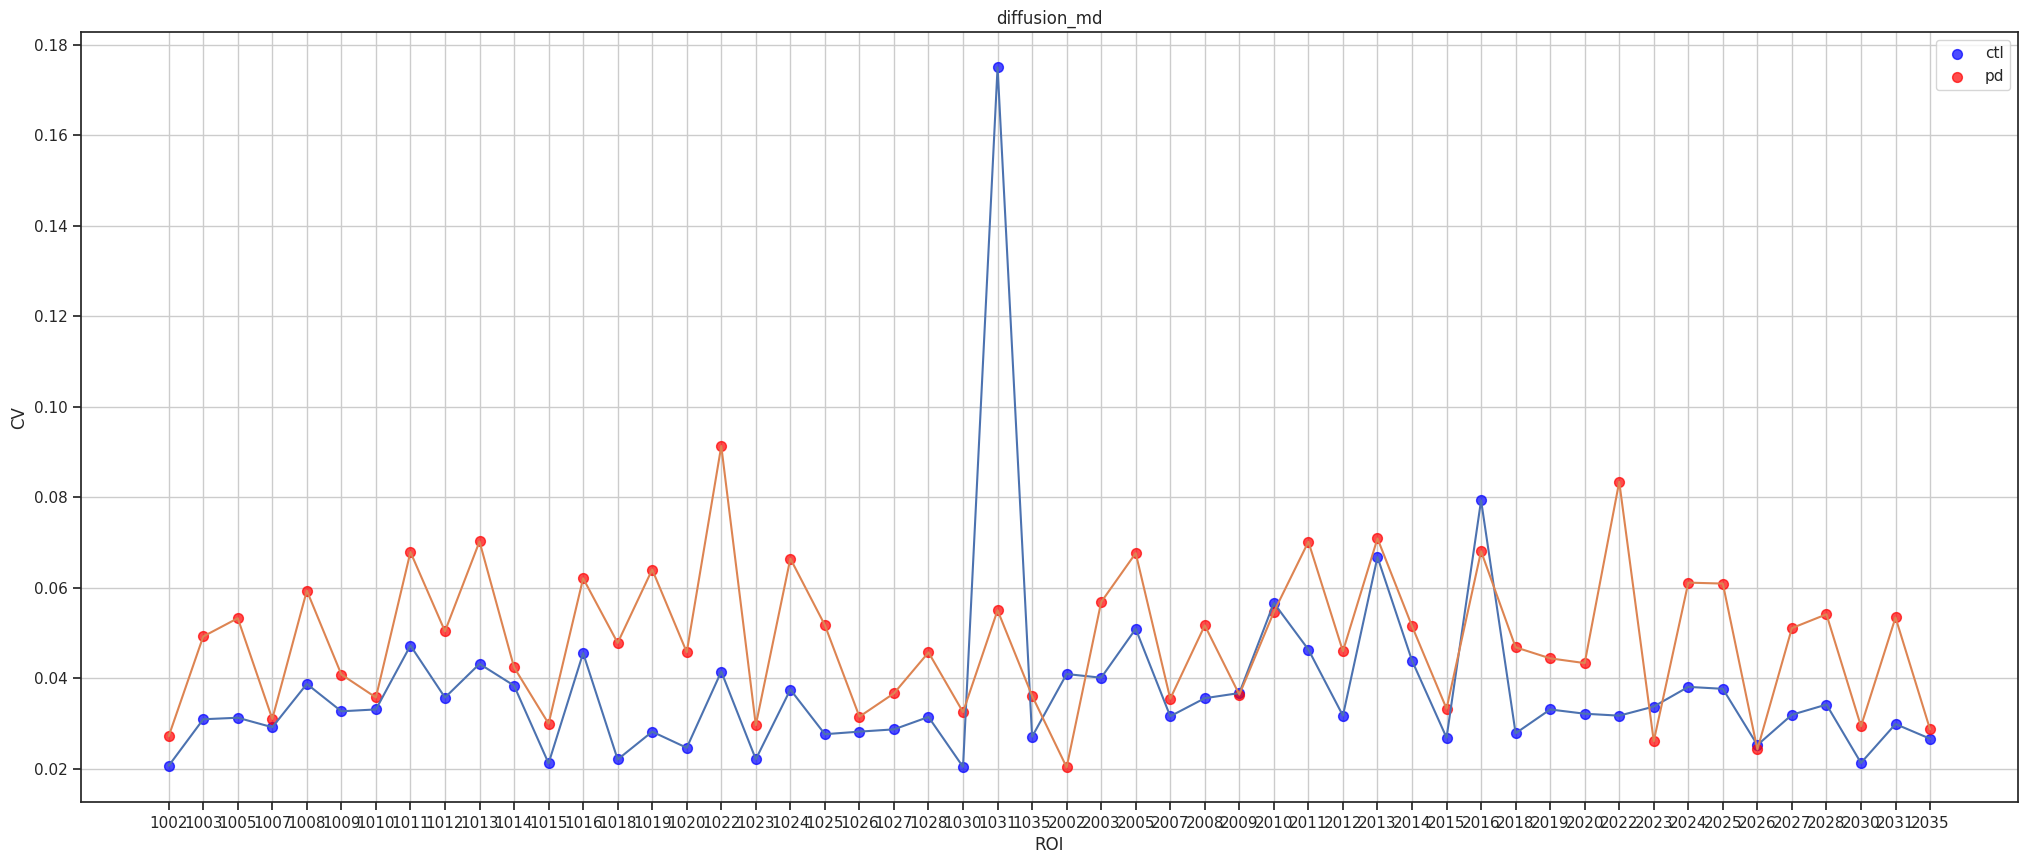

In [44]:
group_by_param = 'ROI'
x_axis = 'ROI'
data_groups = [(ctl_subjects_raw, 'blue', 'ctl'), (pd_subjects_raw, 'red', 'pd')]
StatisticsWrapper.calculate_cv_for_subjects(data_groups, group_by_param, params_to_work_with, x_axis, use_reg=False, fig_size=(25, 10), connect_scatter=True)

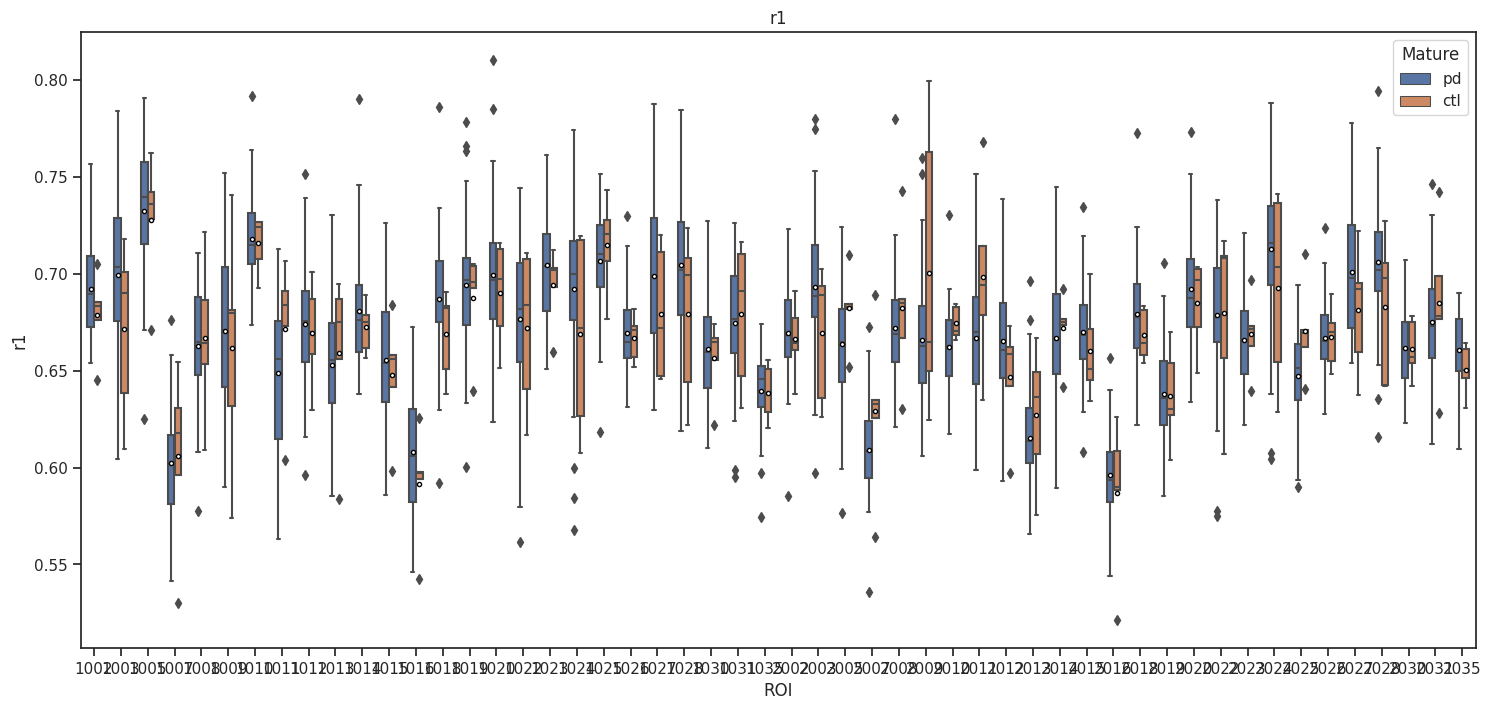

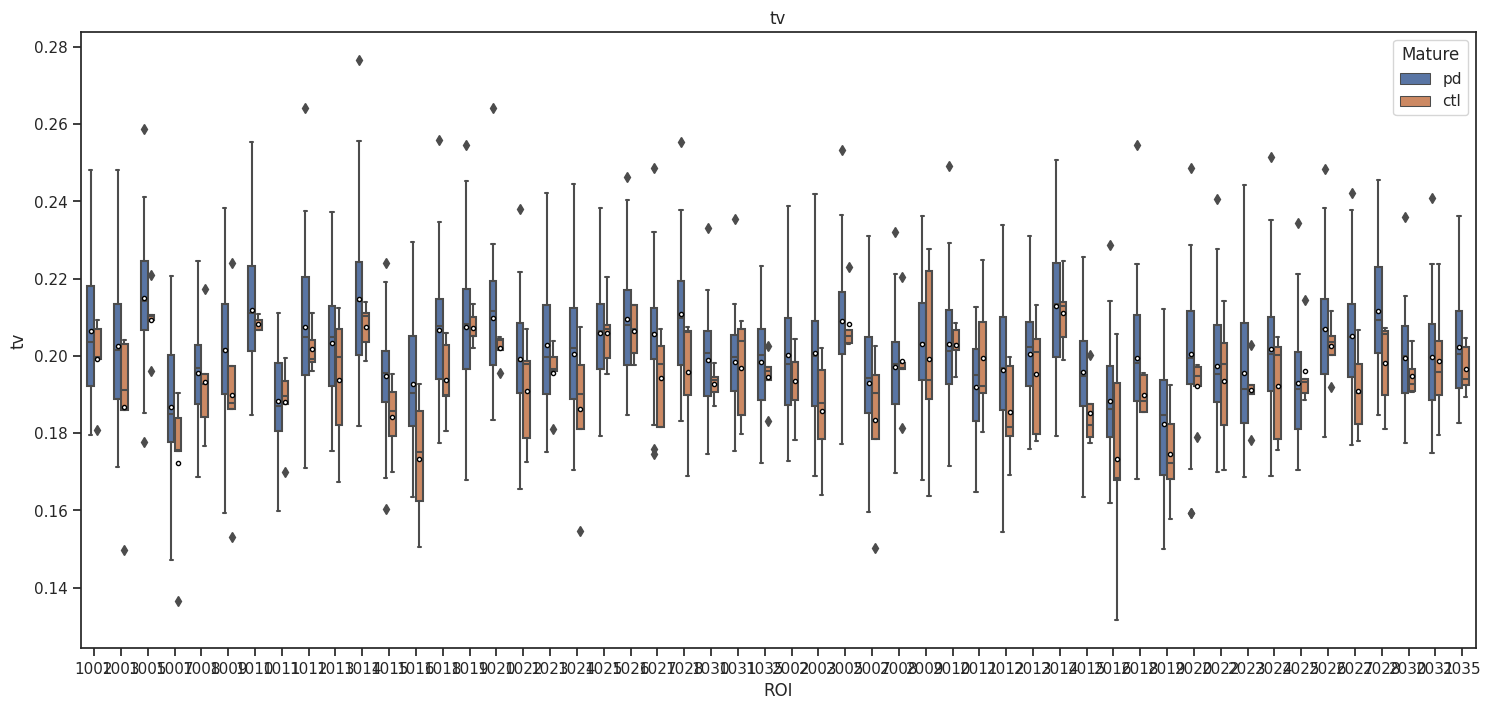

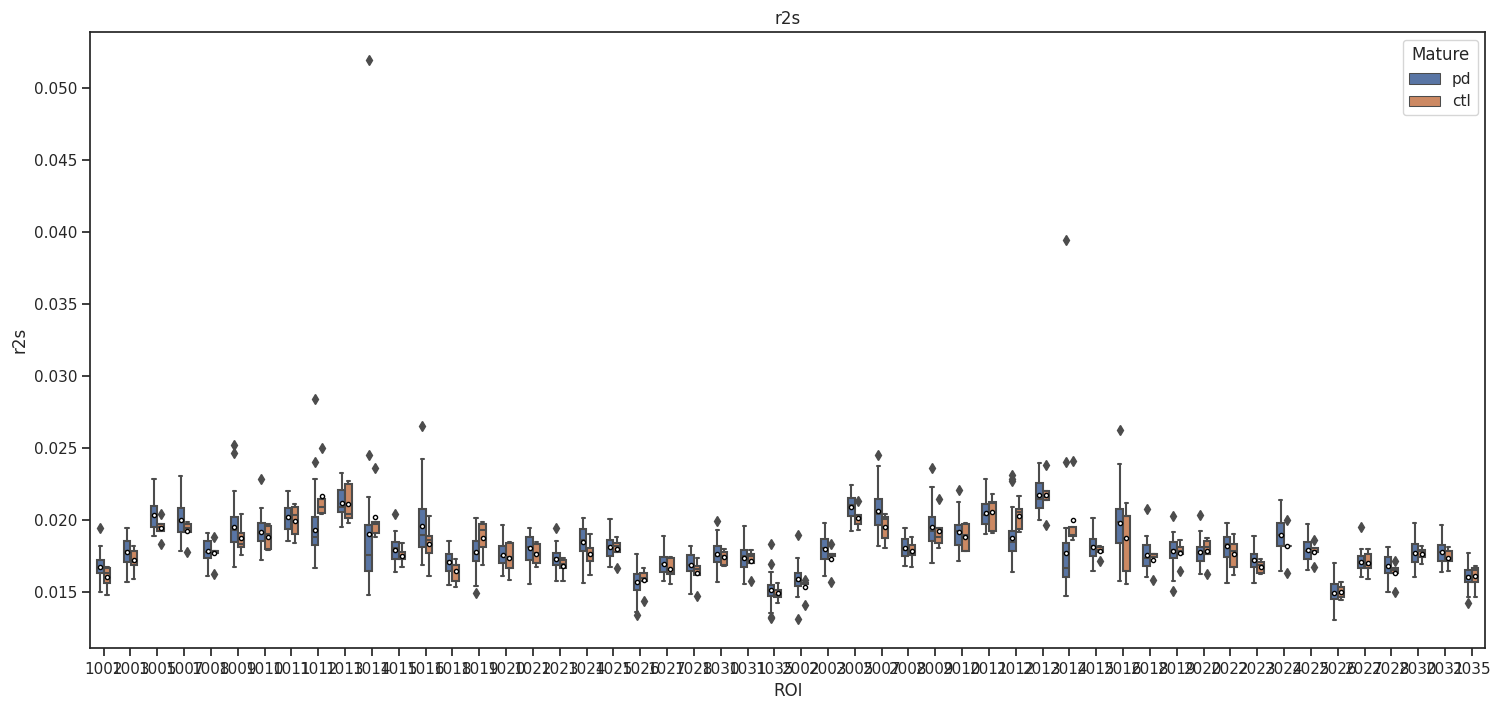

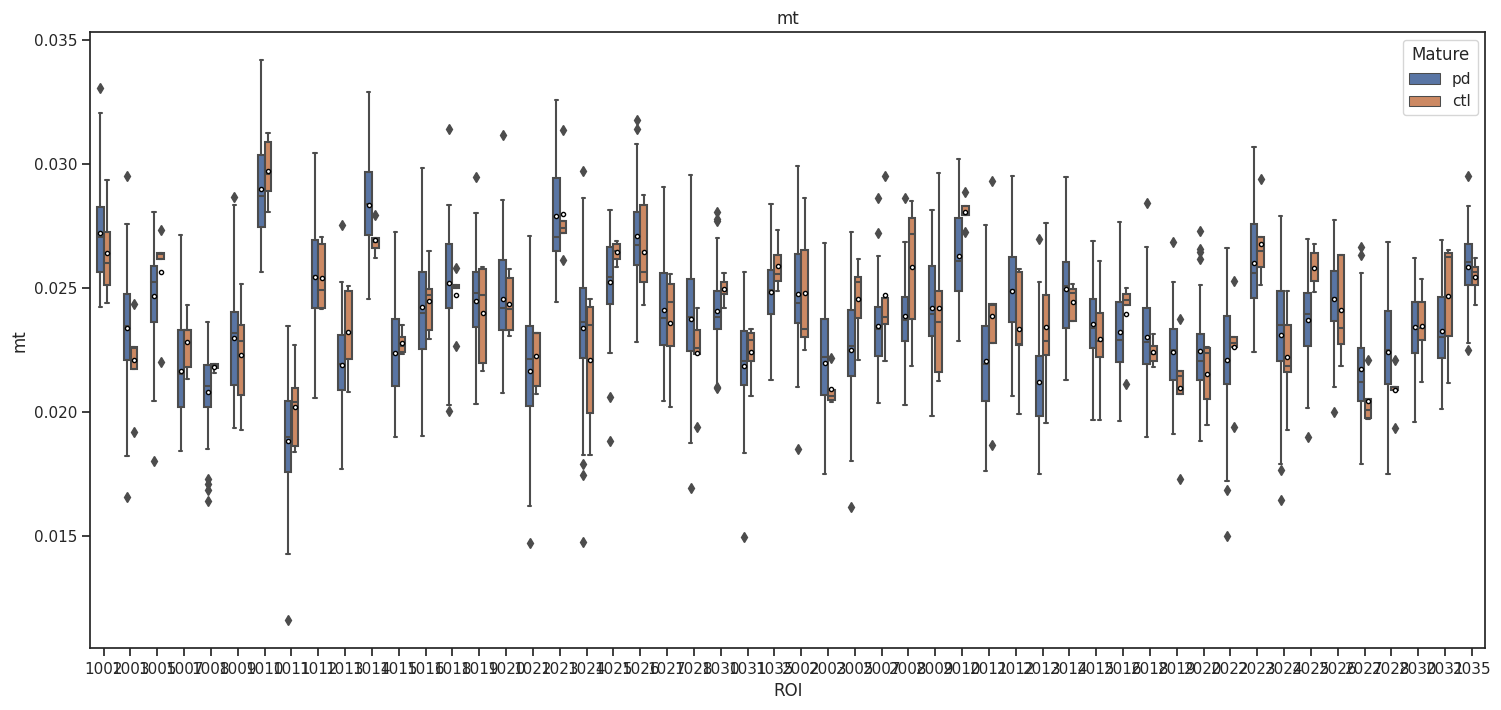

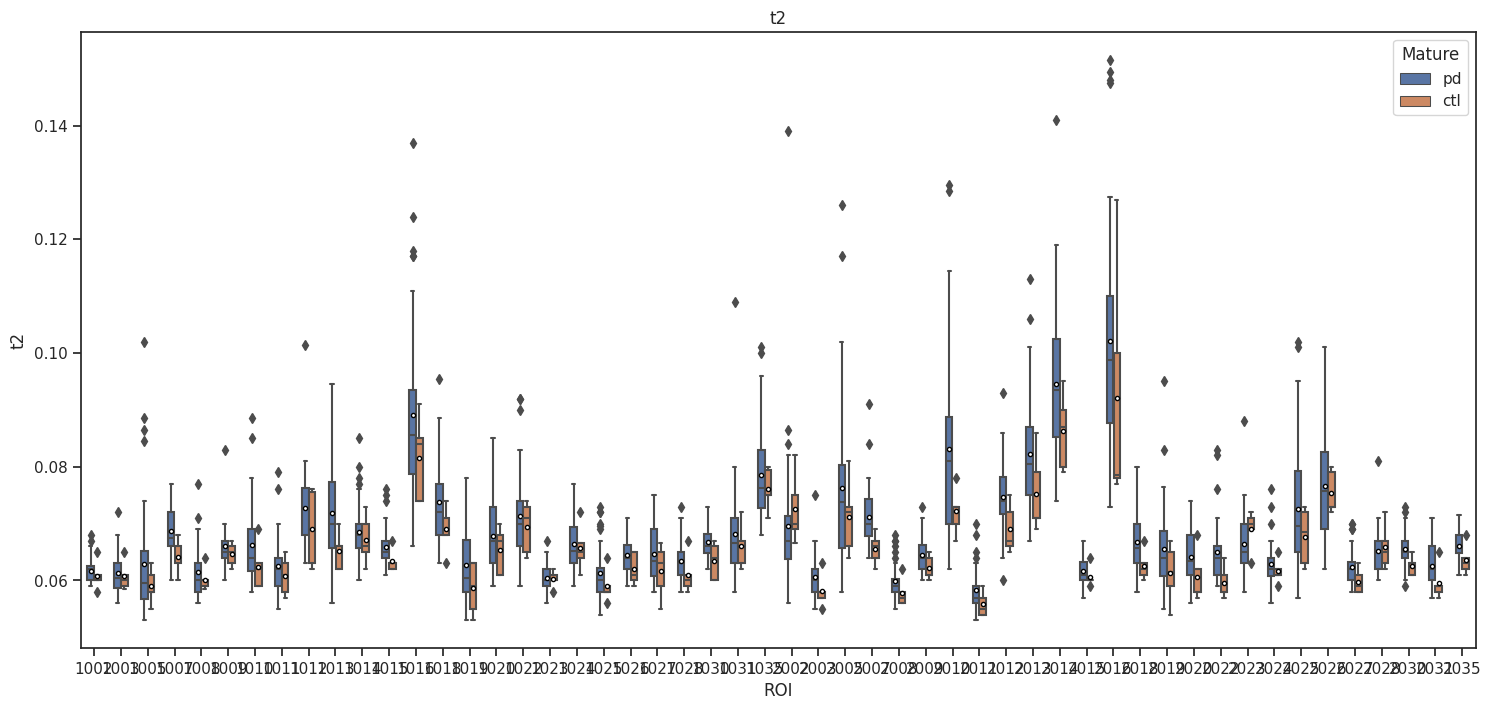

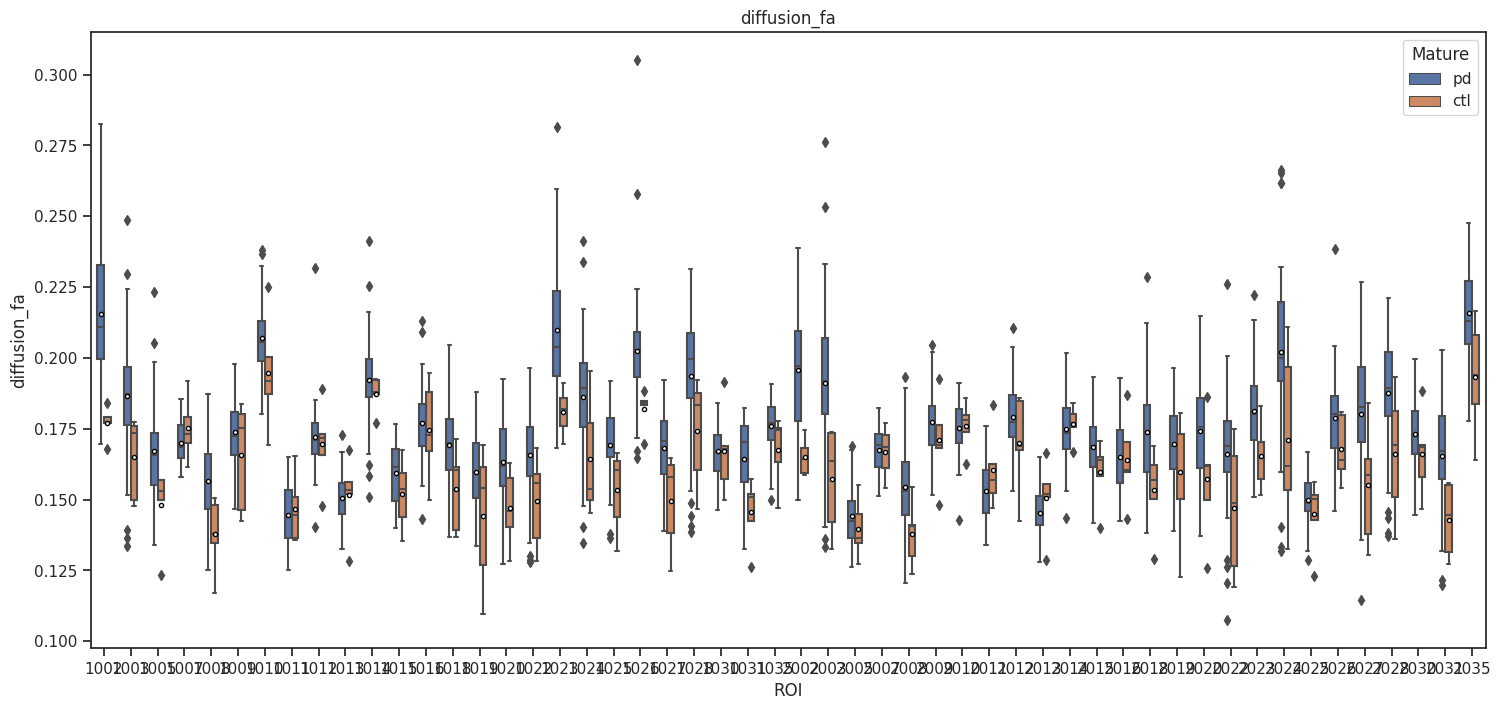

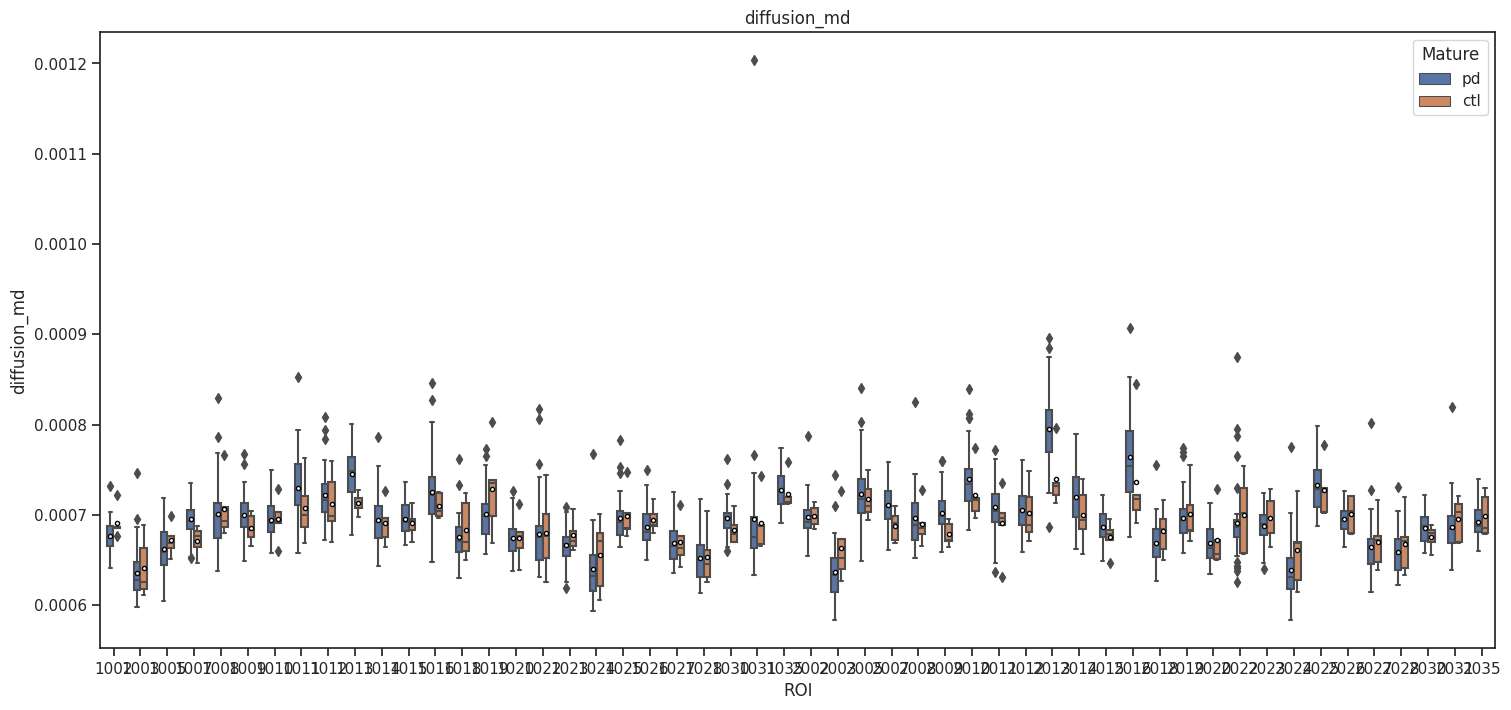

In [16]:
%autoreload 2
StatisticsWrapper.plot_data_per_param_per_roi_next_to_each_other(ctl_subjects_raw, pd_subjects_raw,
                                                                            params_to_work_with,
                                                                            'ctl', 'pd')

## Check correlations on the normalized data

In [9]:
def show_correlations_stats(all_data, ctl_data, pd_data, method):
    clusters_rois = StatisticsWrapper.hierarchical_clustering(all_data, params_to_work_with, 'single',
                                                                title="all")['dendrogram_data']['ivl']
    ctl_result = StatisticsWrapper.roi_correlations(ctl_data, params_to_work_with, clusters_rois,
                                                        group_title='Correlations of ctl group', method=method)
    pd_result = StatisticsWrapper.roi_correlations(pd_data, params_to_work_with, clusters_rois,
                                                     group_title='Correlations of pd group', method=method)

    ctl_std_result = StatisticsWrapper.roi_correlations_std(ctl_data, params_to_work_with, clusters_rois,
                                                        title='Stds of Correlations of ctl group', method=method)
    pd_std_result = StatisticsWrapper.roi_correlations_std(pd_data, params_to_work_with, clusters_rois,
                                                             title='Stds of Correlations of pd group', method=method)
                        
    PlotsManager.plot_heatmap(pd_result - ctl_result, 'differences of pd and ctl', project_name=None)
    ctl_corr_means, pd_corr_means  = show_corr_mean(ctl_result, pd_result, clusters_rois)

    # PlotsManager.plot_colors_on_brain(ctl_data.subjects.iloc[0], ctl_corr_means, chosen_rois_dict, 'ctl_corr', 'heat')
    # PlotsManager.plot_colors_on_brain(ctl_data.subjects.iloc[0], pd_corr_means, chosen_rois_dict, 'pd_corr', 'heat')

def show_corr_mean(ctl_result, pd_result, clusters_rois):
    ctl_result['corr_mean'] = ctl_result.apply(np.mean, axis=1) - 1/ctl_result.shape[0]
    pd_result['corr_mean'] = pd_result.apply(np.mean, axis=1) - 1/pd_result.shape[0]

    fig = plt.figure(figsize=(20, 8))
    ax = fig.add_subplot(1, 1, 1)
    ax.set_title('Average correlations')
    ax.scatter(clusters_rois, ctl_result['corr_mean'].to_numpy(), color='blue', s=20, alpha=0.7, label='ctl')
    ax.scatter(clusters_rois, pd_result['corr_mean'].to_numpy(), color='red', s=20, alpha=0.7, label='pd')

    # Connecting the points with vertical lines
    for x, y1, y2 in zip(clusters_rois, ctl_result['corr_mean'].to_numpy(), pd_result['corr_mean'].to_numpy()):
        plt.plot([x, x], [y1, y2], color='gray', linestyle='--')
        
    ax.set_facecolor('white')
    ax.legend()

    return ctl_result['corr_mean'], pd_result['corr_mean']


/ems/elsc-labs/mezer-a/niv.amos/repos/qMRI Analyzer - Code/statistics_methods/Statistics.py:532: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  clusters = linkage(distances, method=linkage_metric)


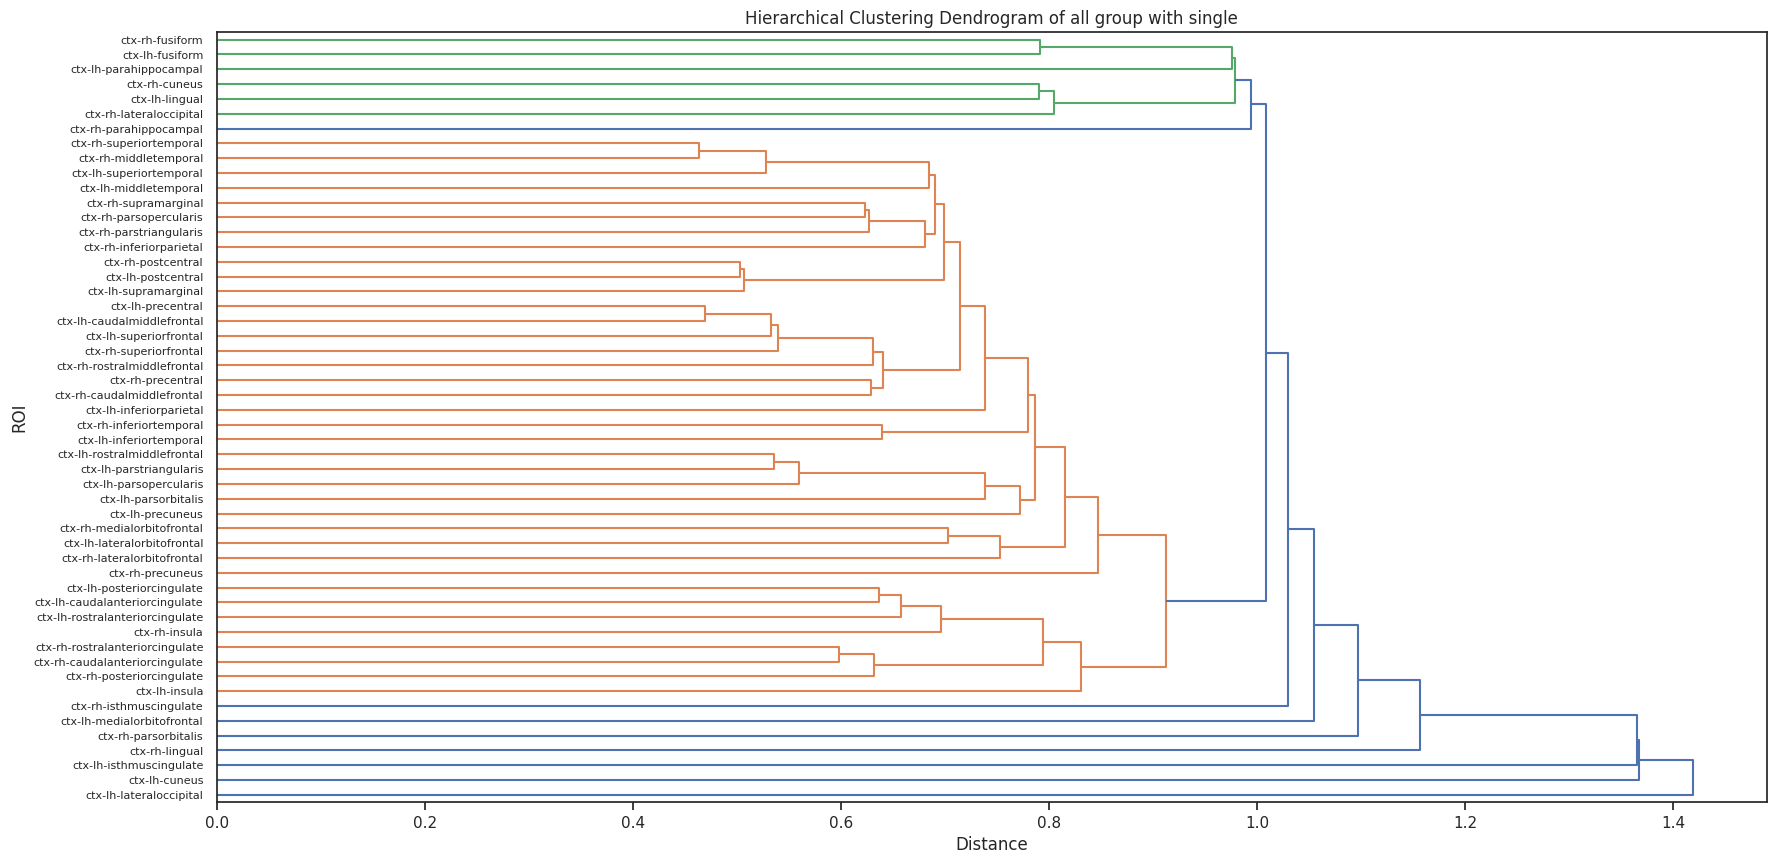

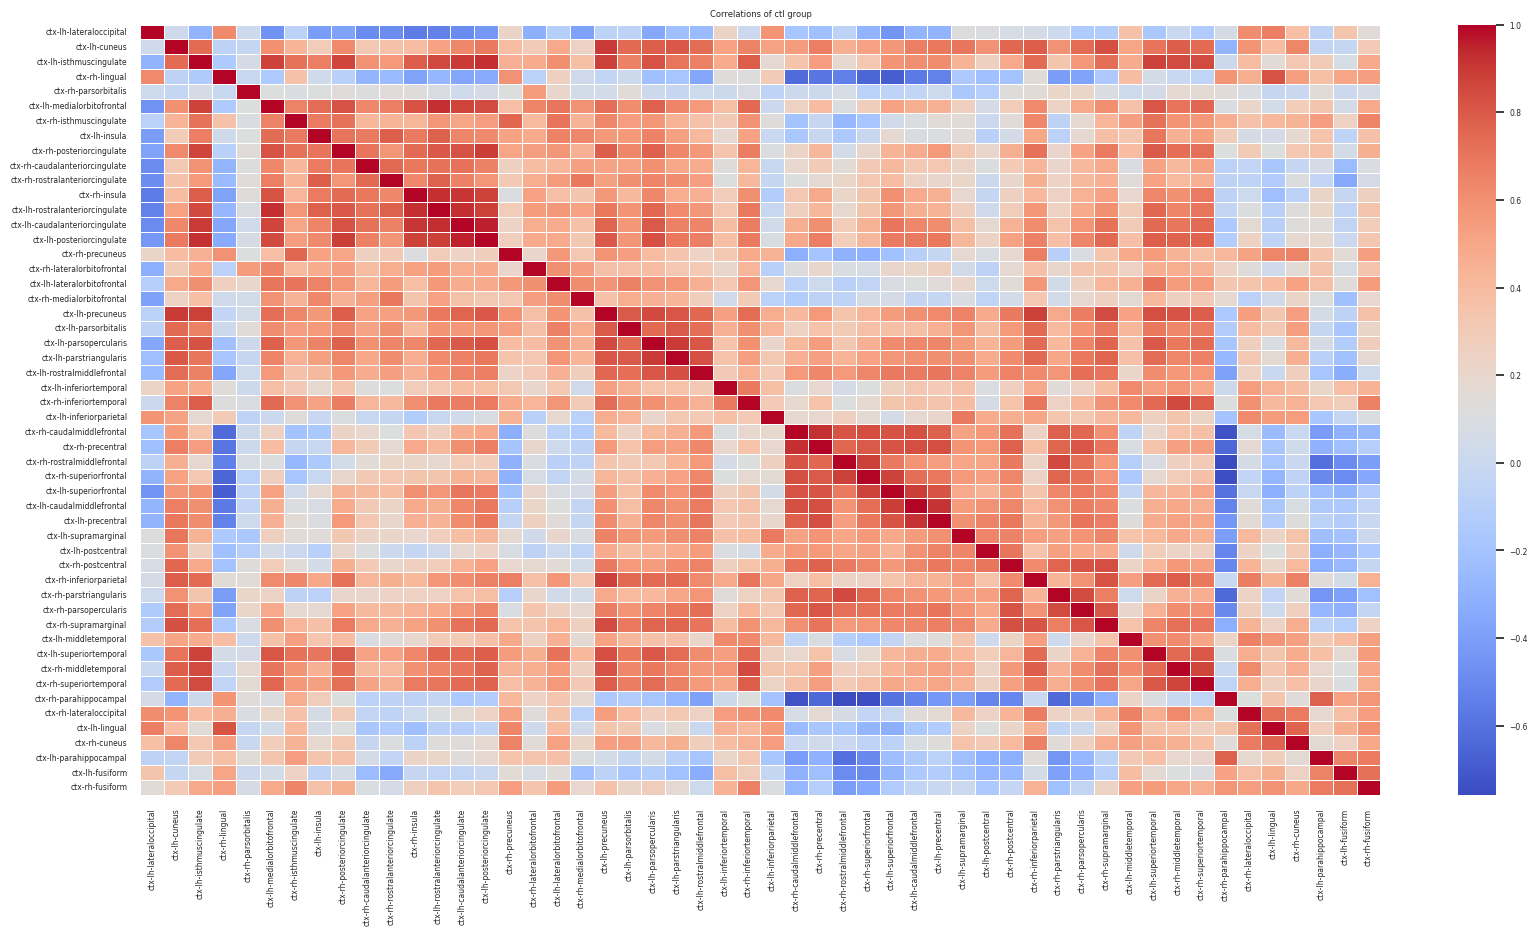

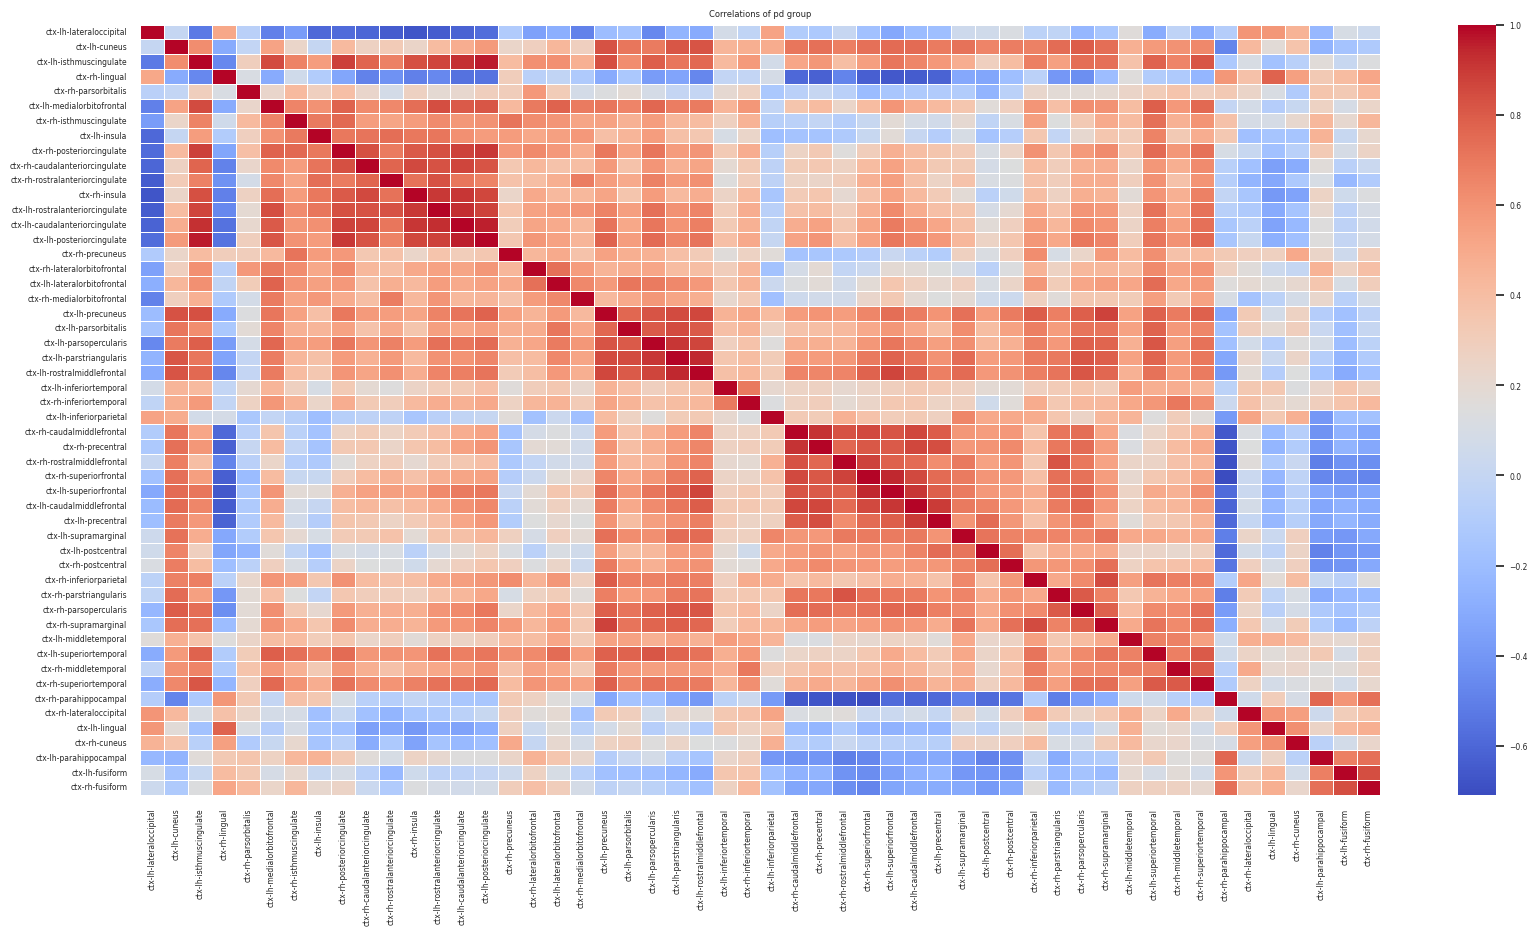

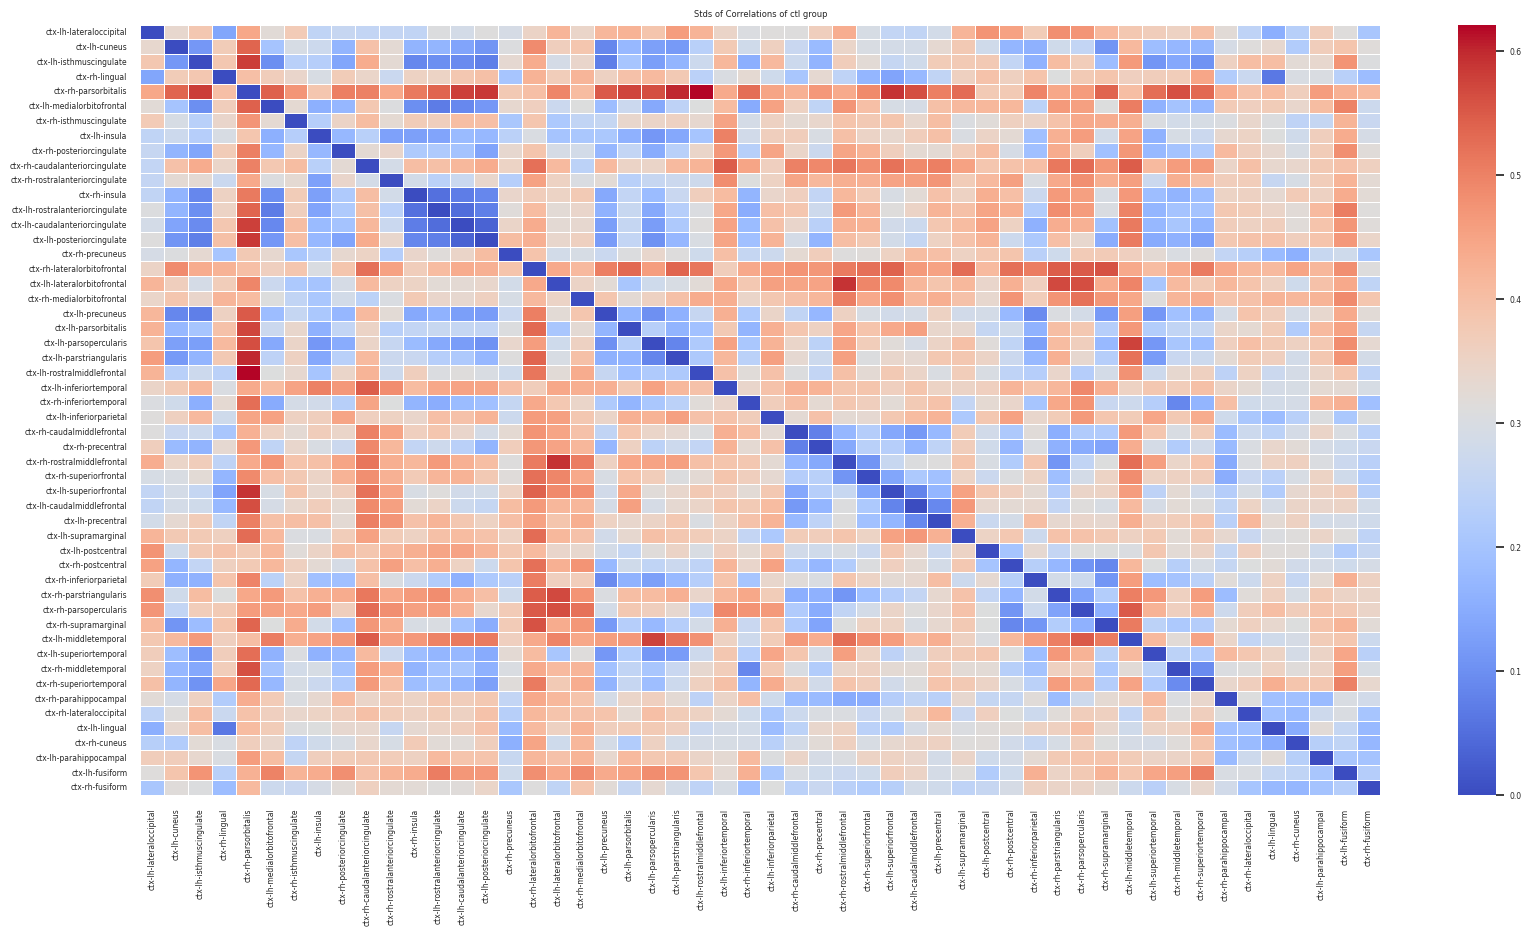

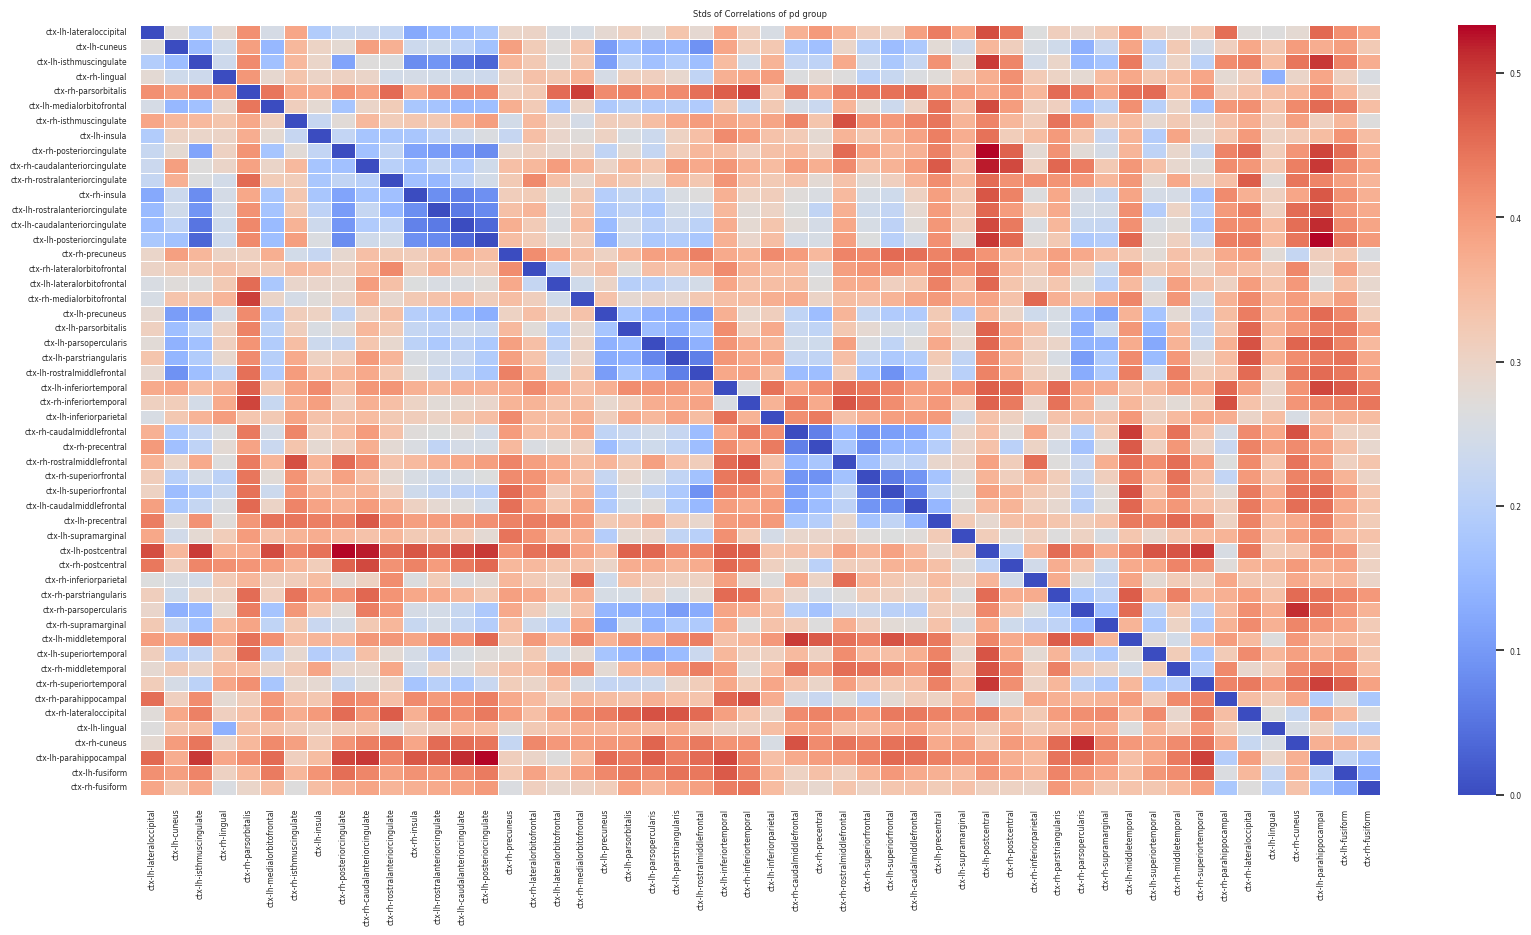

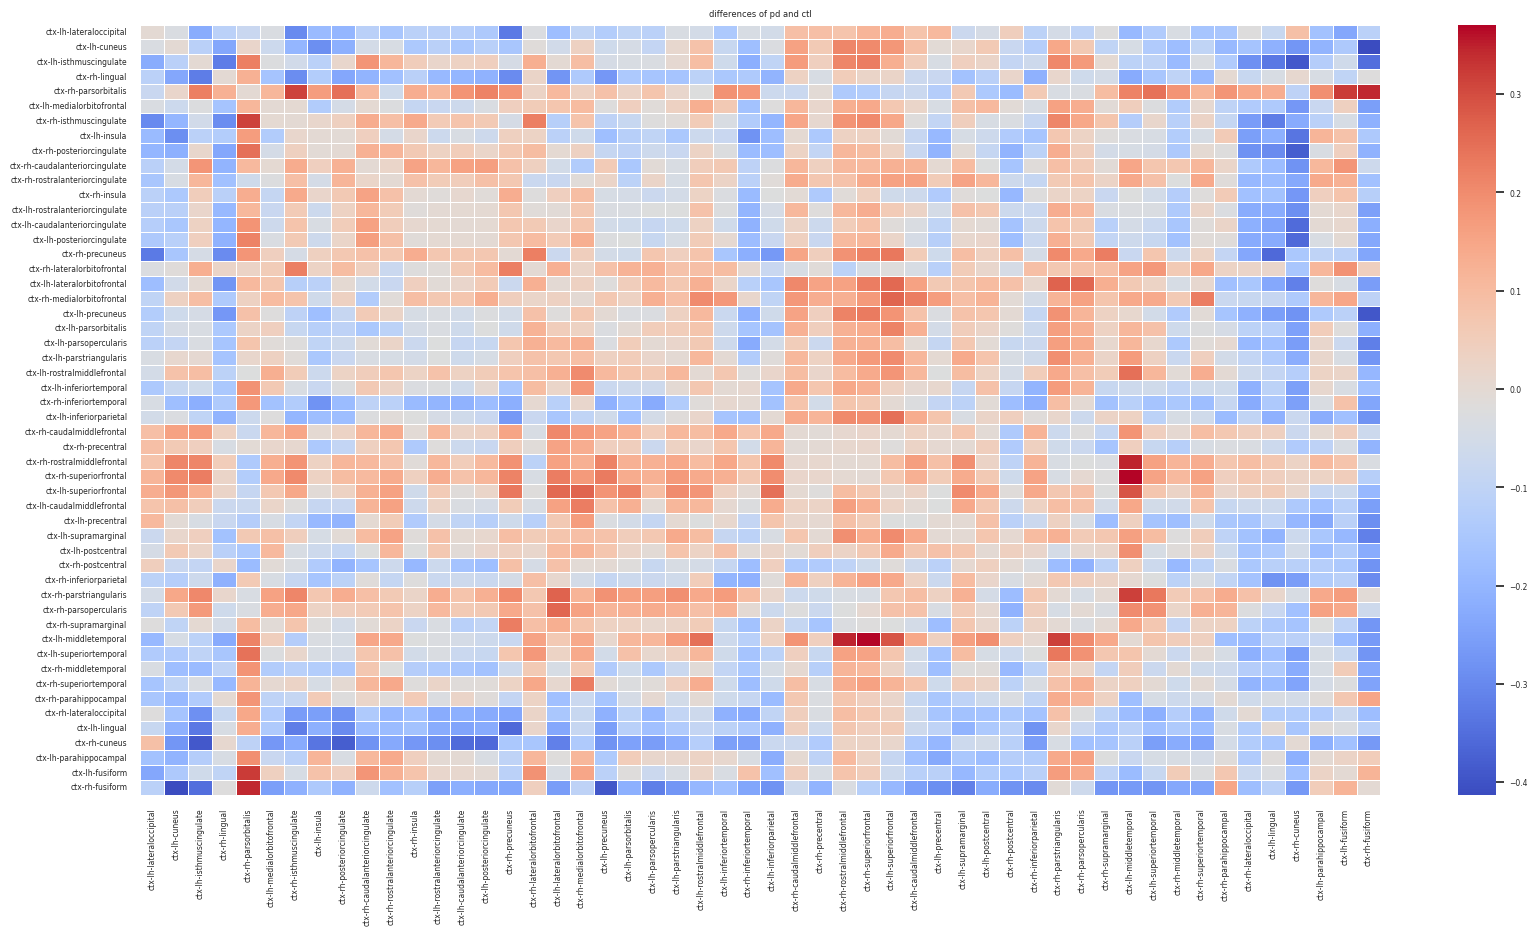

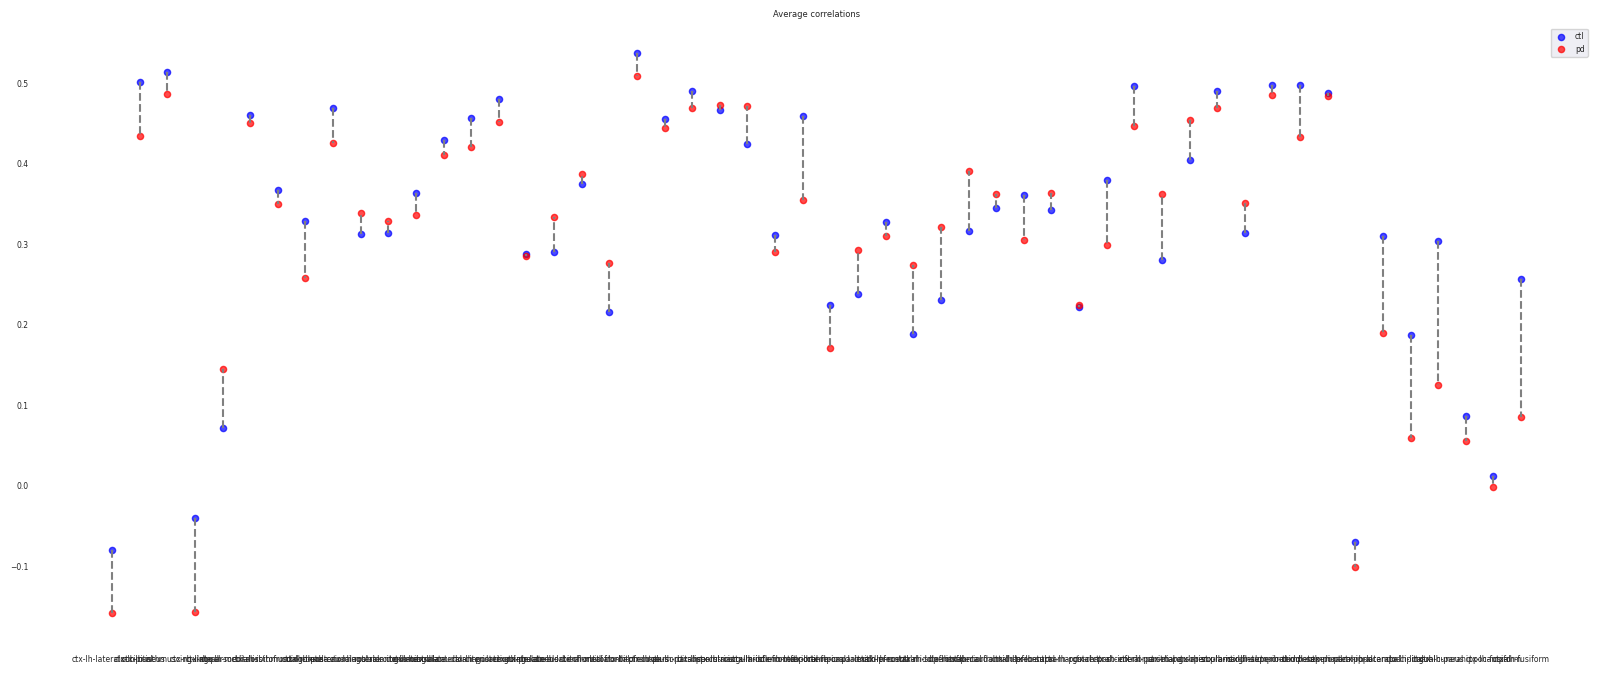

In [10]:
show_correlations_stats(chosen_data_z_score, ctl_subjects_z_score, pd_subjects_z_score, 'pearson')

Check t_test on the young and old groups

In [11]:
StatisticsWrapper.t_test_per_parameter_per_area(ctl_subjects_raw, pd_subjects_raw, chosen_rois_dict, 'ROI', params_to_work_with)

param r1 number of areas with significance differences: 3
param tv number of areas with significance differences: 8
param r2s number of areas with significance differences: 2
param mt number of areas with significance differences: 7
param t2 number of areas with significance differences: 2
param diffusion_fa number of areas with significance differences: 20
param diffusion_md number of areas with significance differences: 12


Subjects clustering 

In [12]:
def reduce_dim(model, data, drop_label=True):
    if drop_label:
        res = model.fit_transform(data.drop(columns='label'))
    else:
        res = model.fit(data.drop(columns='label'), data['label']).transform(data.drop(columns='label'))  

    column_names = [f"var_{i + 1}" for i in range(res.shape[1])]  # Generate dynamic column names
    reduced_data = pd.DataFrame(res, columns=column_names, index=data.index)

    reduced_data['label'] = data['label']
    # print(f'kl divergence: {model.kl_divergence_}')
    return reduced_data

In [13]:
ctl_features_df = pd.pivot_table(ctl_subjects_z_score, index='subjects', columns='ROI', values=params_to_work_with, aggfunc='sum')
pd_features_df = pd.pivot_table(pd_subjects_z_score, index='subjects', columns='ROI', values=params_to_work_with, aggfunc='sum')
data_features_df = pd.pivot_table(chosen_data_z_score, index='subjects', columns='ROI', values=params_to_work_with, aggfunc='sum')

ctl_mask = ctl_features_df.index
pd_mask = pd_features_df.index

# Assign labels directly to data_reduced_tsne DataFrame
data_features_df.loc[ctl_mask, 'label'] = 'ctl'
data_features_df.loc[pd_mask, 'label'] = 'pd'

In [14]:
dim = 0.95
pca = PCA(n_components=2)
tsne = TSNE(n_components=2, perplexity=3, random_state=36)

data_reduced_pca = reduce_dim(pca, data_features_df, drop_label=True)
data_reduced_tsne = reduce_dim(tsne, data_features_df, drop_label=True)

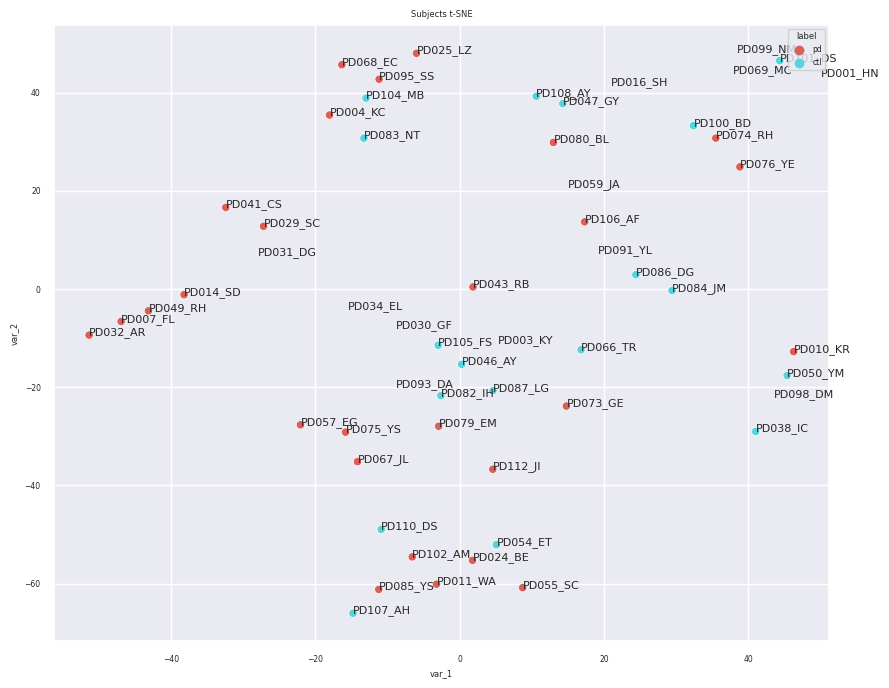

In [15]:
fig, ax = plt.subplots(figsize=(10,8))

sns.scatterplot(
    x="var_1", y="var_2",
    hue='label',
    palette=sns.color_palette("hls", 2),
    data=data_reduced_tsne,
    legend="full",
    ax=ax
    ).set_title('Subjects t-SNE')

for i, txt in enumerate(data_reduced_tsne.index):
    ax.annotate(txt, (data_reduced_tsne['var_1'][i], data_reduced_tsne['var_2'][i]), fontsize=8)


In [ ]:
def tsne_cluster(config=None):
    with wandb.init(config=config):
        config=wandb.config

        tsne = TSNE(n_components=2, perplexity=config.perplexity, random_state=config.seed)
        data_reduced_tsne = reduce_dim(tsne, data_features_df)

        young_df_tsne = data_reduced_tsne.loc[young_features_df.index]
        old_df_tsne = data_reduced_tsne.loc[old_features_df.index]

        fig, ax = plt.subplots(figsize=(10,8))
        ax.scatter(young_df_tsne['var_1'], young_df_tsne['var_2'], color='blue', label='young')
        ax.scatter(old_df_tsne['var_1'], old_df_tsne['var_2'], color='red', label='old')

        for i, txt in enumerate(young_df_tsne.index):
            ax.annotate(txt, (young_df_tsne['var_1'][i], young_df_tsne['var_2'][i]), fontsize=8)

        for i, txt in enumerate(old_df_tsne.index):
            ax.annotate(txt, (old_df_tsne['var_1'][i], old_df_tsne['var_2'][i]), fontsize=8) 

        plt.legend()
        plt.title(f'Subjects t-SNE perplexity {config.perplexity}')
        wandb.log({f'results': wandb.Image(plt)})
        plt.close()

config = {
    "method": "grid",
    "parameters": {
        "perplexity": {"values": list(range(2, 5))},
        "seed": {"values": [0, 42, 36]}
    }
}

sweep_id = wandb.sweep(sweep=config, project="tsne_optimize_no_outliers")
wandb.agent(sweep_id, function=tsne_cluster)

Rois clustering

In [68]:
all_features_df = chosen_data_z_score[params_to_work_with]

young_mask = young_subjects_z_score.index
old_mask = old_subjects_z_score.index

# Assign labels directly to DataFrame
all_features_df.loc[young_mask, 'label'] = 'young'
all_features_df.loc[old_mask, 'label'] = 'old'

/tmp/ipykernel_378631/490072393.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_features_df.loc[young_mask, 'label'] = 'young'


In [79]:
# model = TSNE(n_components=2, perplexity=100, random_state=0)
model = PCA(n_components=2)
all_df_reduced = reduce_dim(model, all_features_df)

In [61]:
def plot_clusters_of_rois(reduced_data, prev_data, title):

    hue = []

    for roi in prev_data['ROI_name']:
        for lobe, lobe_values in constants.LOBES.items():
            if roi in lobe_values:
                hue.append(lobe)

    sns.scatterplot(
        x="var_1", y="var_2",
        hue=hue,
        palette=sns.color_palette("husl", len(constants.LOBES.keys())),
        data=reduced_data,
        legend="full",
        ).set_title(title)

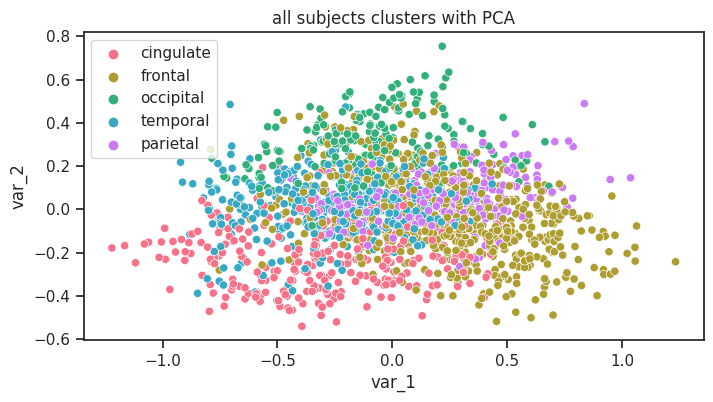

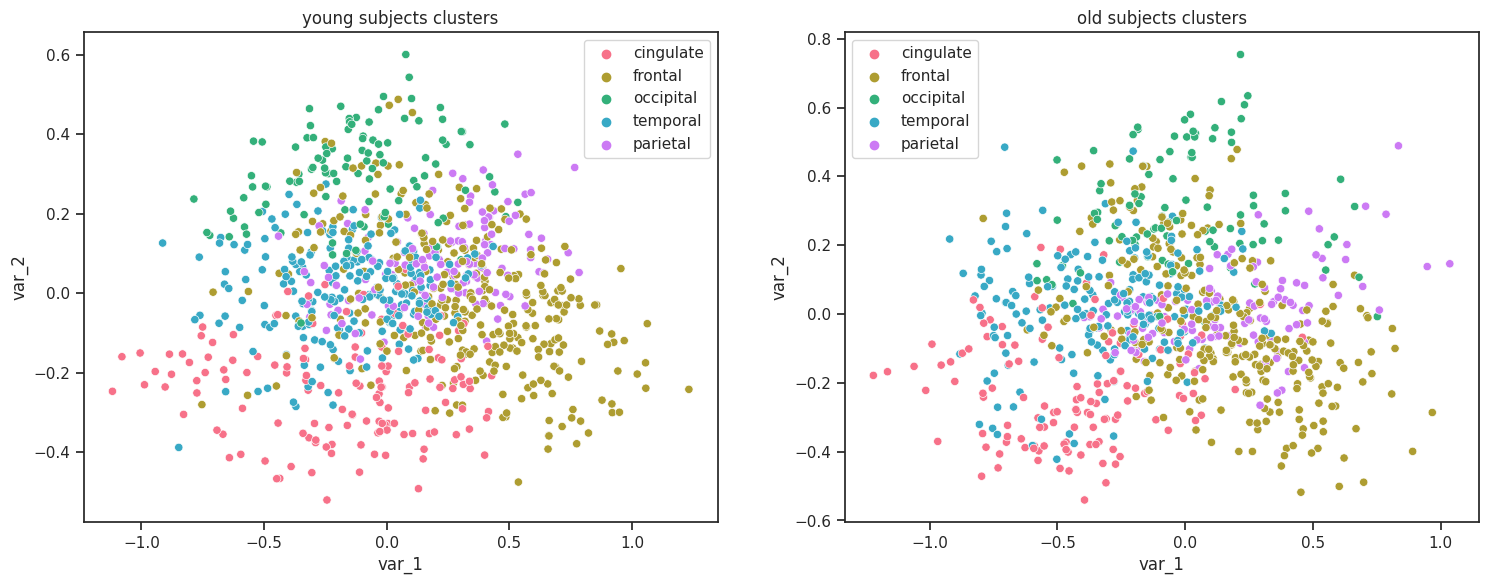

In [80]:
plt.figure(figsize=(8, 4))
plot_clusters_of_rois(all_df_reduced, chosen_data_z_score, title="all subjects clusters with PCA")
plt.figure(figsize=(18, 14))
plt.subplot(2, 2, 1)
plot_clusters_of_rois(all_df_reduced[all_df_reduced.label == 'young'], young_subjects_z_score, title="young subjects clusters")
plt.subplot(2, 2, 2)
plot_clusters_of_rois(all_df_reduced[all_df_reduced.label == 'old'], old_subjects_z_score, title="old subjects clusters")

In [44]:
all_df_reduced.groupby('label').describe()

var_1                                                               
       count      mean       std       min       25%       50%       75%   
label                                                                      
old    832.0 -0.070633  0.388679 -1.220295 -0.330355 -0.070011  0.214216  \
young  936.0  0.062785  0.387701 -1.117997 -0.206130  0.071484  0.325340   

                 var_2                                                     
            max  count      mean       std       min       25%       50%   
label                                                                      
old    1.035823  832.0 -0.005110  0.217446 -0.540490 -0.138068 -0.014017  \
young  1.231804  936.0  0.004542  0.194737 -0.520456 -0.123661  0.004104   

                           
            75%       max  
label                      
old    0.128102  0.754286  
young  0.124323  0.600012

In [ ]:
def tsne_cluster(config=None):
    with wandb.init(config=config):
        config=wandb.config

        tsne = TSNE(n_components=2, perplexity=config.perplexity, random_state=42)
        all_df_reduced = reduce_dim(tsne, all_features_df)

        plot_clusters_of_rois(all_df_reduced, chosen_data_z_score, title=f"subjects clusters with perplexity {config.perplexity}")
        wandb.log({f'results': wandb.Image(plt)})
        plt.close()

config = {
    "method": "grid",
    "parameters": {
        "perplexity": {"values": [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]},
        # "seed": {"values": [0, 42, 36]}
    }
}

sweep_id = wandb.sweep(sweep=config, project="tsne_optimize_rois_clustering")
wandb.agent(sweep_id, function=tsne_cluster)

In [ ]:
%autoreload 2
StatisticsWrapper.roi_correlations_by_age_by_each_roi(chosen_data_z_score, params_to_work_with,
                                                        title='Stds of Correlations of young group', method='pearson')